In [1]:
import numpy as np
import torch
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics.functional import auroc
from sklearn.metrics import roc_auc_score

import os
import re
import sys
plt.style.use('bmh')
plt.rcParams['svg.fonttype'] = 'none'
os.chdir('project/learning_causal_discovery/')

from run.shallowmind.api.infer import prepare_inference

/home/charon/anaconda3/envs/dev_test/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# root directory of model checkpoint and config files
work_dir = 'work_dir'

In [3]:
import os

def search_cfg_ckpt(target_dir, keyword=None, screen=None, target_suffix=["ckpt", "py"]):
    # search files by given keywords and suffix, and screened keywords under target directory
    find_res = []
    target_suffix_dot = ["." + suffix for suffix in target_suffix]
    walk_generator = os.walk(target_dir)
    for root_path, dirs, files in walk_generator:
        if len(files) < 1:
            continue
        for file in files:
            file_name, suffix_name = os.path.splitext(file)
            if suffix_name in target_suffix_dot:
                file_name = os.path.join(root_path, file)
                # keyword check
                if keyword is not None:
                    _check = 0
                    for word in keyword:
                        if word in file_name:
                            _check += 1
                    if screen is not None:
                        for screen_word in screen:
                                if screen_word in file_name:
                                    _check -= 1
                    if _check == len(keyword):
                            find_res.append(file_name)
                else:
                    find_res.append(file_name)
    return find_res

def cfg_ckpt2dict(files):
    # convert config list and ckpt list in to dict {cfg: ckpt}
    cfgs = [cfg for cfg in files if '.py' in cfg]
    ckpts = [ckpt for ckpt in files if '.ckpt' in ckpt]
    dict = {}
    for cfg in cfgs:
        root = cfg.split('/')[-2]
        for i, ckpt in enumerate(ckpts):
            if ckpt.split('/')[-3] == root:
                dict[cfg] = ckpt
                break
        try:
            del ckpts[i]
        except:
            pass
        
    return dict

In [4]:
# helper functions
# plotting
games = ['DonkeyKong', 'Pitfall', 'SpaceInvaders']
methods = ["corr_score", "mi_score", "gc_score", "lingam_score","LSTM_score", "TCN_score", "Transformer_score"]
label = ["Pearson Correlation", "Mutual Information", "Linear Granger Causality", "ICA-LiNGAM", "LSTM", "TCN", "Transformer"]
cls = [218, 240, 178, 146, 212, 185, 62, 179, 195, 91, 191, 192 ,30, 128, 184, 36, 65, 154, 10, 31, 93]

def digits2color(digits):
    d_group = [digits[i:i+3] for i in range(0, len(digits), 3)]
    colors = [tuple((np.array(d)/255).tolist()) for d in d_group]
    return colors

cls = digits2color(cls)
cls = cls*4

def plot_regular_results(res, conditions, error_bar=False, plot_kwargs={}, save_dir=None):

    if error_bar:
        seeded_res = [[res[c][g][j][seed] for seed in res[c][g][j]] for c in conditions for g in res[c] for j in methods]
        # (mean, std)
        seeded_res = [(np.mean(seeds), np.std(seeds)) for seeds in seeded_res]
    fig, ax1 = plt.subplots(figsize=(9, 7), constrained_layout=True, dpi=300)

    title = plot_kwargs.get('title', f'Methods Comparison on DonkeyKong\n')
    ax1.set_title(title, fontdict={'family': 'Serif', 'size': 14})
    ax1.set_xlabel(
        'AUROC', fontdict={'family': 'Serif', 'size': 14})

    # bars combo
    width = plot_kwargs.get('width', 0.35)
    interval = plot_kwargs.get('interval', 4)
    total = len(conditions) * interval
    y_labels = plot_kwargs.get('y_labels', [])
    bar_height = plot_kwargs.get('bar_height', 0.35)

    # go through the scores of different level of augmentation
    x = [np.linspace(i-3*width, i+3*width, len(methods)) for i in range(0,total,interval)]
    x = np.concatenate(x).reshape(-1)

    if error_bar:
        y = [res[c][g][j] for c in conditions for g in res[c] for j in methods]
    else:
        y = [value for c in conditions for g in res[c] for j in methods for seed, value in res[c][g][j].items()]

    for i in range(len(methods)):
        if error_bar:
            mean, std = [s[0] for s in seeded_res], [s[1] for s in seeded_res]
            p = ax1.barh(x[i::len(methods)], mean[i::len(methods)], xerr=std[i::len(methods)],
                     color=cls[i], align='center', height=bar_height, label=label[i],
                     error_kw={'linewidth': 2, 'capsize': 6})
            ax1.bar_label(p, fmt='%.3f', fontfamily='Serif', fontsize=14)
        else:
            ax1.barh(x[i::len(methods)], y[i::len(methods)], color=cls[i], align='center', height=bar_height, label=label[i])

    ax1.set_xlim([0.4, 1])
    ax1.set_xticks(np.linspace(0.4, 0.9, 6))
    ax1.xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)
    ax1.axvline(0.5, color='#6e9ece', alpha=0.25)  # median position
    ax1.set_yticks(x) if not y_labels else ax1.set_yticks(range(0, total, interval))
    ax1.set_yticklabels(labels=y_labels, fontdict={'family': 'Serif', 'size': 14})
    ax1.legend(loc='lower right', prop={'family': 'Serif', 'size': 14},)
    if save_dir is not None:
        plt.savefig(f"{save_dir}.svg")

def collect_inferences(file_cfg=dict(), target_dir='.cache/sim_data/mos_auc_result'):
    # get result from traditional method
    # file name format: game={game}-method={method}-seed={seed}-note={note}.pkl
    game = file_cfg.get('game', ['DonkeyKong'])
    method = file_cfg.get('method', ['corr', 'mi', 'gc', 'lingam'])
    seed = file_cfg.get('seed', [42])
    note = file_cfg.get('note', ['default'])
    result = {}

    for _note in note:
        result[_note] = {}
        for _game in game:
            result[_note][_game] = {}
            for _method in method:
                result[_note][_game][f'{_method}_score'] = {}
                for _seed in seed:
                    file_name = os.path.join(target_dir, f'game={_game}-method={_method}-seed={_seed}-note={_note}.pkl')
                    file = pickle.load(open(file_name, 'rb'))
                    if _method in ['mi', 'lingam']:
                        # directly calculate AUC (coeff, adjacency matrices)
                        result[_note][_game][f'{_method}_score'][_seed] = roc_auc_score(np.array(file[_method]['label']), np.array(file[_method]['pred']))
                    elif _method in ['corr']:
                        # directly calculate AUC (coeff, adjacency matrices)
                        result[_note][_game][f'{_method}_score'][_seed] = roc_auc_score(np.array(file[_method]['label']), np.abs(np.array(file[_method]['pred'])))
                    elif _method in ['gc']:
                        # calculate AUC on the 1 - p_value
                        result[_note][_game][f'{_method}_score'][_seed] = roc_auc_score(np.array(file[_method]['label']), np.array(file[_method]['pred']))

    return result


def models_inference(keyword, result, target_dir=root_dir, screen=None, cfg_hook=None):
    mi_dicts = cfg_ckpt2dict(search_cfg_ckpt(target_dir, screen=screen, keyword=keyword))
    print(f'total models number: {len(mi_dicts)}')
    for idx, (cfg, ckpt) in tqdm(enumerate(mi_dicts.items())):
        seed = int(cfg.split('/')[-2].split('_')[-1])
        di, mi = prepare_inference(cfg, ckpt)
        mi = mi.cuda()
        if cfg_hook is not None:
            di.data_cfg = cfg_hook(di.data_cfg)
        di.setup()
        di.data_cfg.test_batch_size = 1024
        dl = di.test_dataloader()
        preds = []
        labels = []
        mi.eval()
        with torch.no_grad():
            for i, (x, y) in tqdm(enumerate(dl), total=len(dl), desc=f'{mi.hparams.model.backbone.type}'):
                pred = mi({k: v.cuda() for k, v in x.items()})
                preds.append(pred.softmax(dim=-1)[:, 1].detach().cpu())
                labels.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0)
        labels = torch.cat(labels, dim=0)
        if result.get(f'{mi.hparams.model.backbone.type}_score', None) is None:
            result[f'{mi.hparams.model.backbone.type}_score'] = {}
        result[f'{mi.hparams.model.backbone.type}_score'][seed] = auroc(preds, labels, pos_label=1)
    return result

### Regular Runtime

In [6]:
condition = 'default'
game = 'DonkeyKong'
# collect inference result from traditional methods
result = collect_inferences(file_cfg={'game': [game],
                                        'method': ['corr', 'mi', 'gc', 'lingam'],
                                        'seed': [42, 1207, 12, 7, 3057],
                                        'note': [condition]}, target_dir='.cache/sim_data/mos_auc_result')
# get result from deep learning method
result[condition][game] = models_inference(keyword=["fold_seed"], result=result[condition][game],
                          target_dir=work_dir, screen=['noise'])

total models number: 15


0it [00:00, ?it/s]/home/charon/anaconda3/envs/dev_test/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)

TCN: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:30<00:00,  1.15s/it]
1it [00:32, 32.97s/it]/home/charon/anaconda3/envs/dev_test/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)

Transformer: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:25<00:00,  1.01it/s

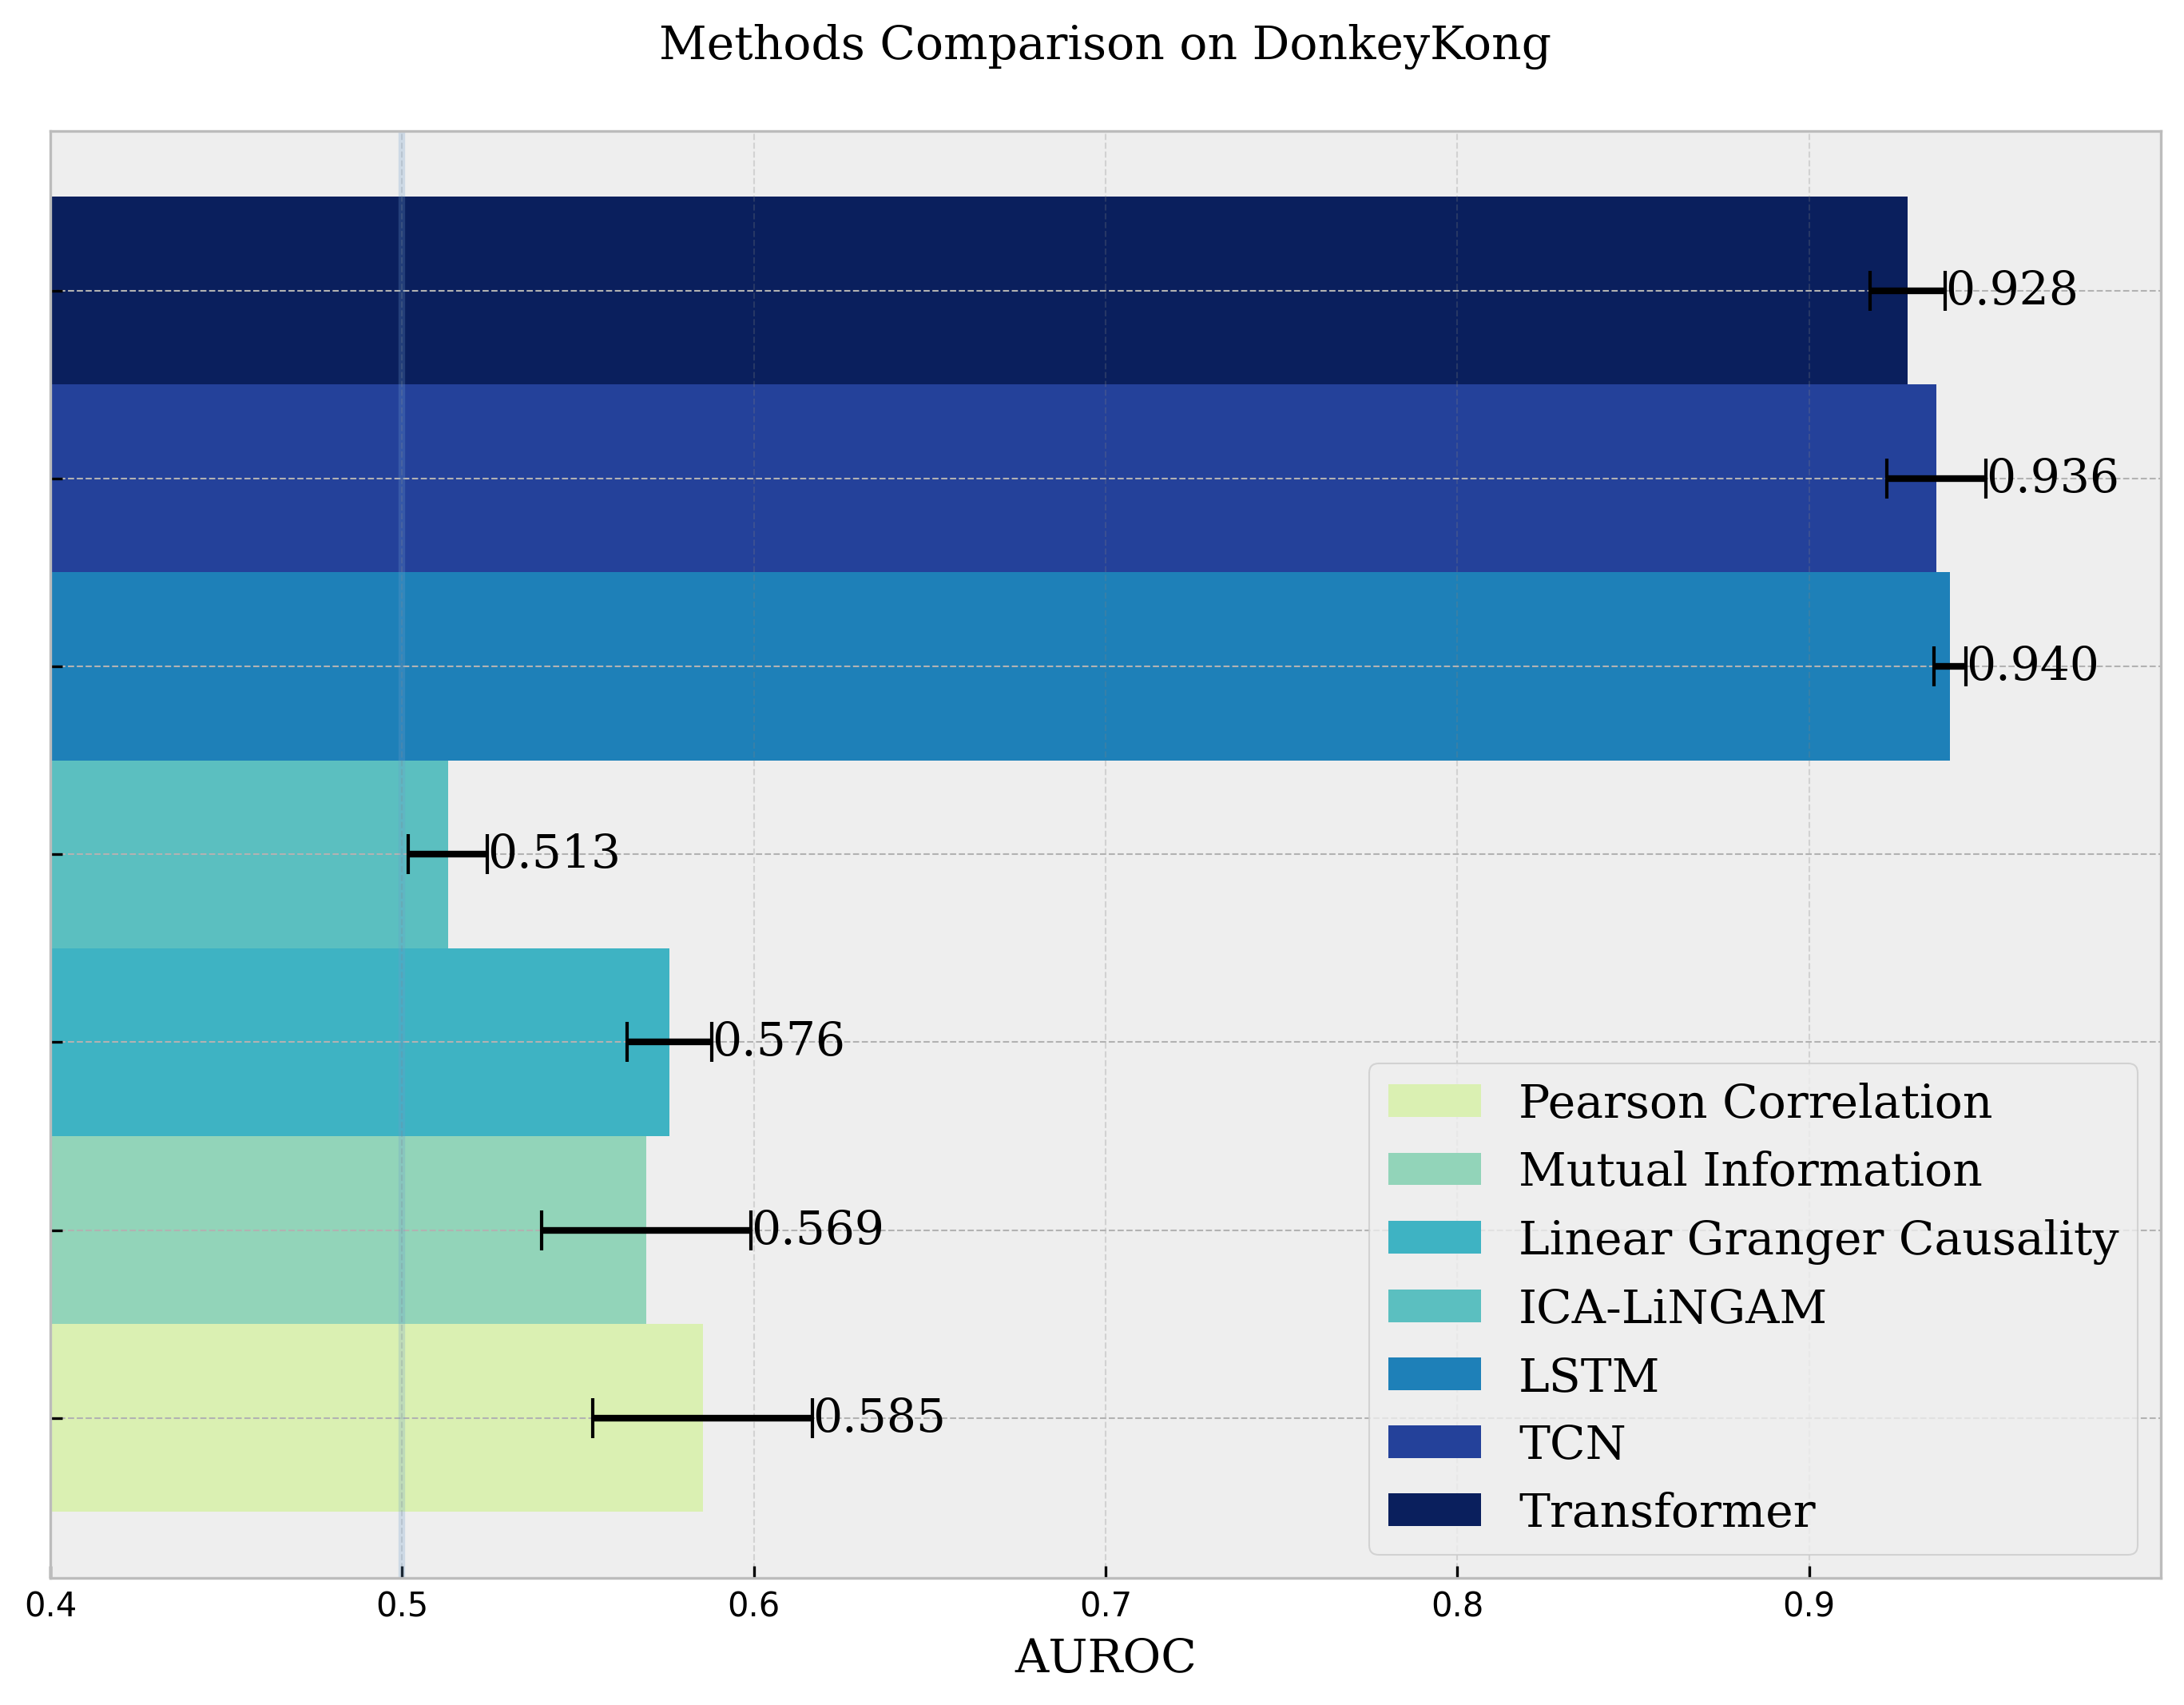

In [7]:
plot_regular_results(result, error_bar=True, conditions=['default'], save_dir='figures/Figure 4. Methods/regular')

### Noise Runtime

In [8]:
conditions = ['0.1noise', '0.3noise', '0.5noise']
game = 'DonkeyKong'
# collect inference result from traditional methods
result.update(collect_inferences(file_cfg={'game': [game],
                                        'method': ['corr', 'mi', 'gc', 'lingam'],
                                        'seed': [42, 1207, 12, 7, 3057],
                                        'note': conditions}, target_dir='.cache/sim_data/mos_auc_result'))
# get result from deep learning method
for condition in ['0.1noise', '0.3noise', '0.5noise']:
    result[condition][game] = models_inference(keyword=[condition], result=result[condition][game],
                                                target_dir=work_dir)

total models number: 15


0it [00:00, ?it/s]/home/charon/anaconda3/envs/dev_test/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)

TCN: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [01:12<00:00,  2.78s/it]
1it [01:12, 72.80s/it]/home/charon/anaconda3/envs/dev_test/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)

Transformer: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [01:11<00:00,  2.76s/it

total models number: 15


0it [00:00, ?it/s]/home/charon/anaconda3/envs/dev_test/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)

LSTM: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [01:12<00:00,  2.80s/it]
1it [01:13, 73.36s/it]/home/charon/anaconda3/envs/dev_test/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)

LSTM: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [01:12<00:00,  2.79s/it

total models number: 15


0it [00:00, ?it/s]/home/charon/anaconda3/envs/dev_test/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)

LSTM: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [01:12<00:00,  2.78s/it]
1it [01:12, 72.77s/it]/home/charon/anaconda3/envs/dev_test/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)

LSTM: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [01:12<00:00,  2.79s/it

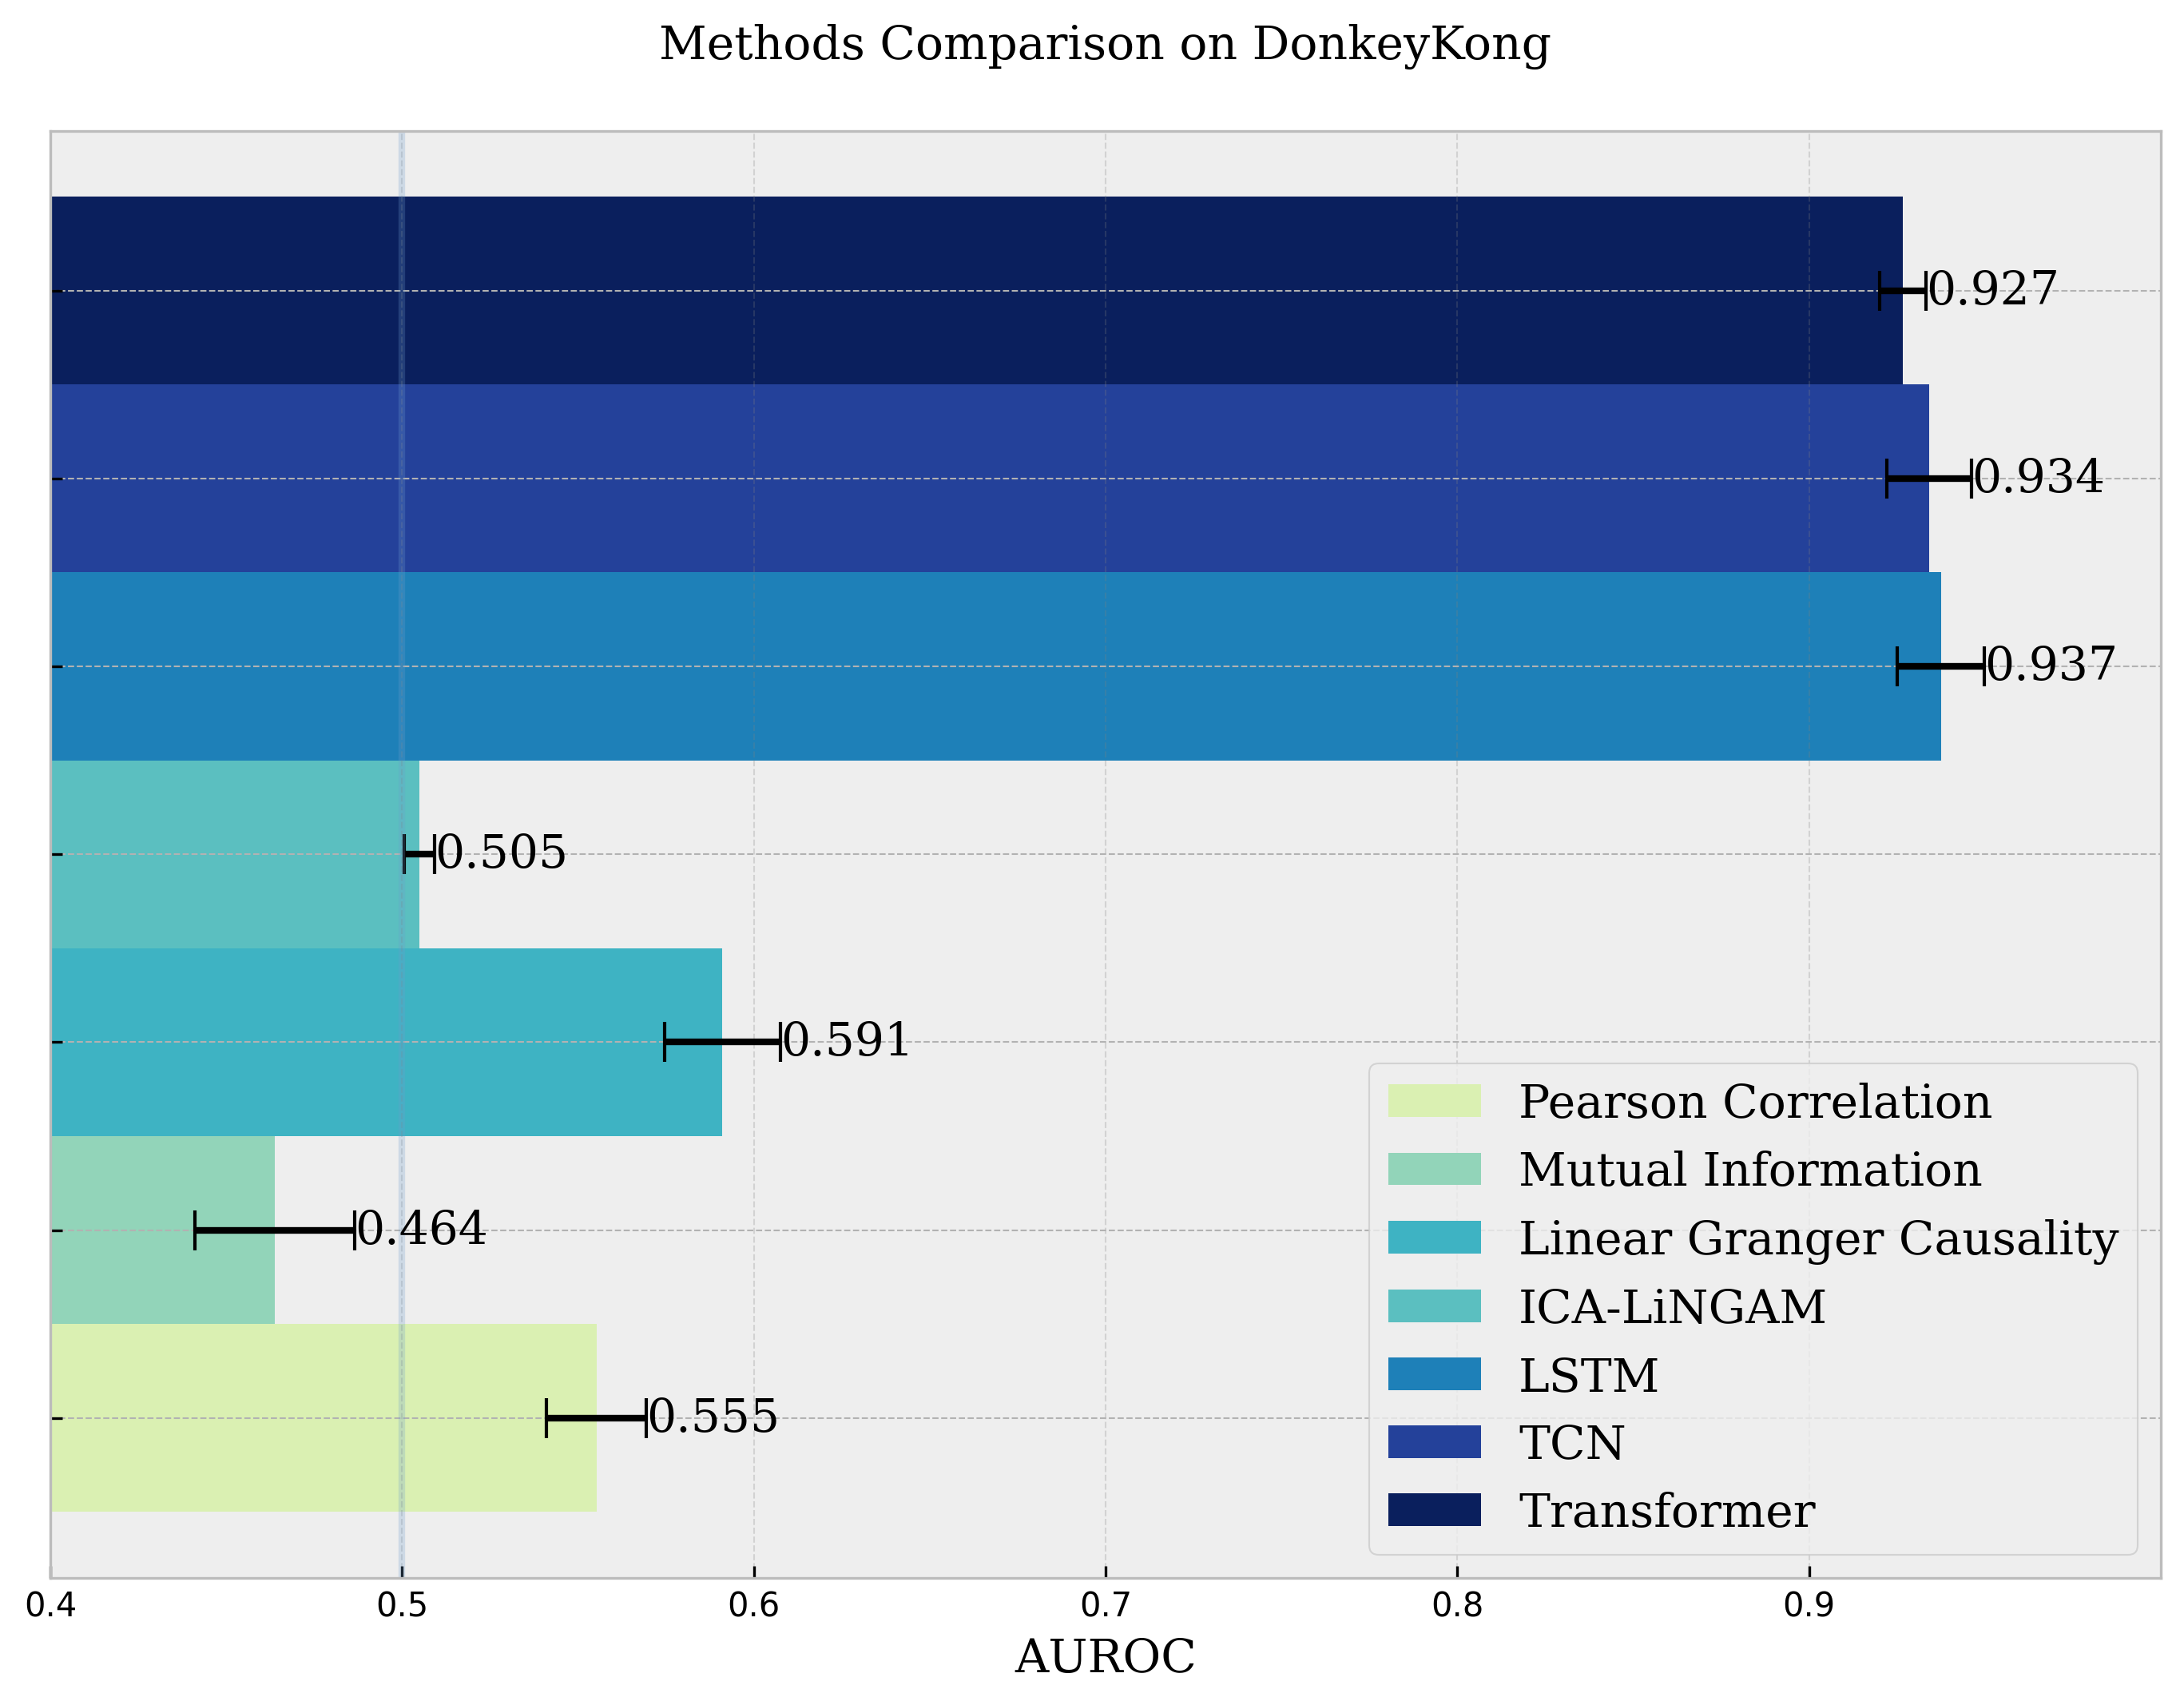

In [9]:
plot_regular_results(result, error_bar=True, conditions=['0.1noise'])

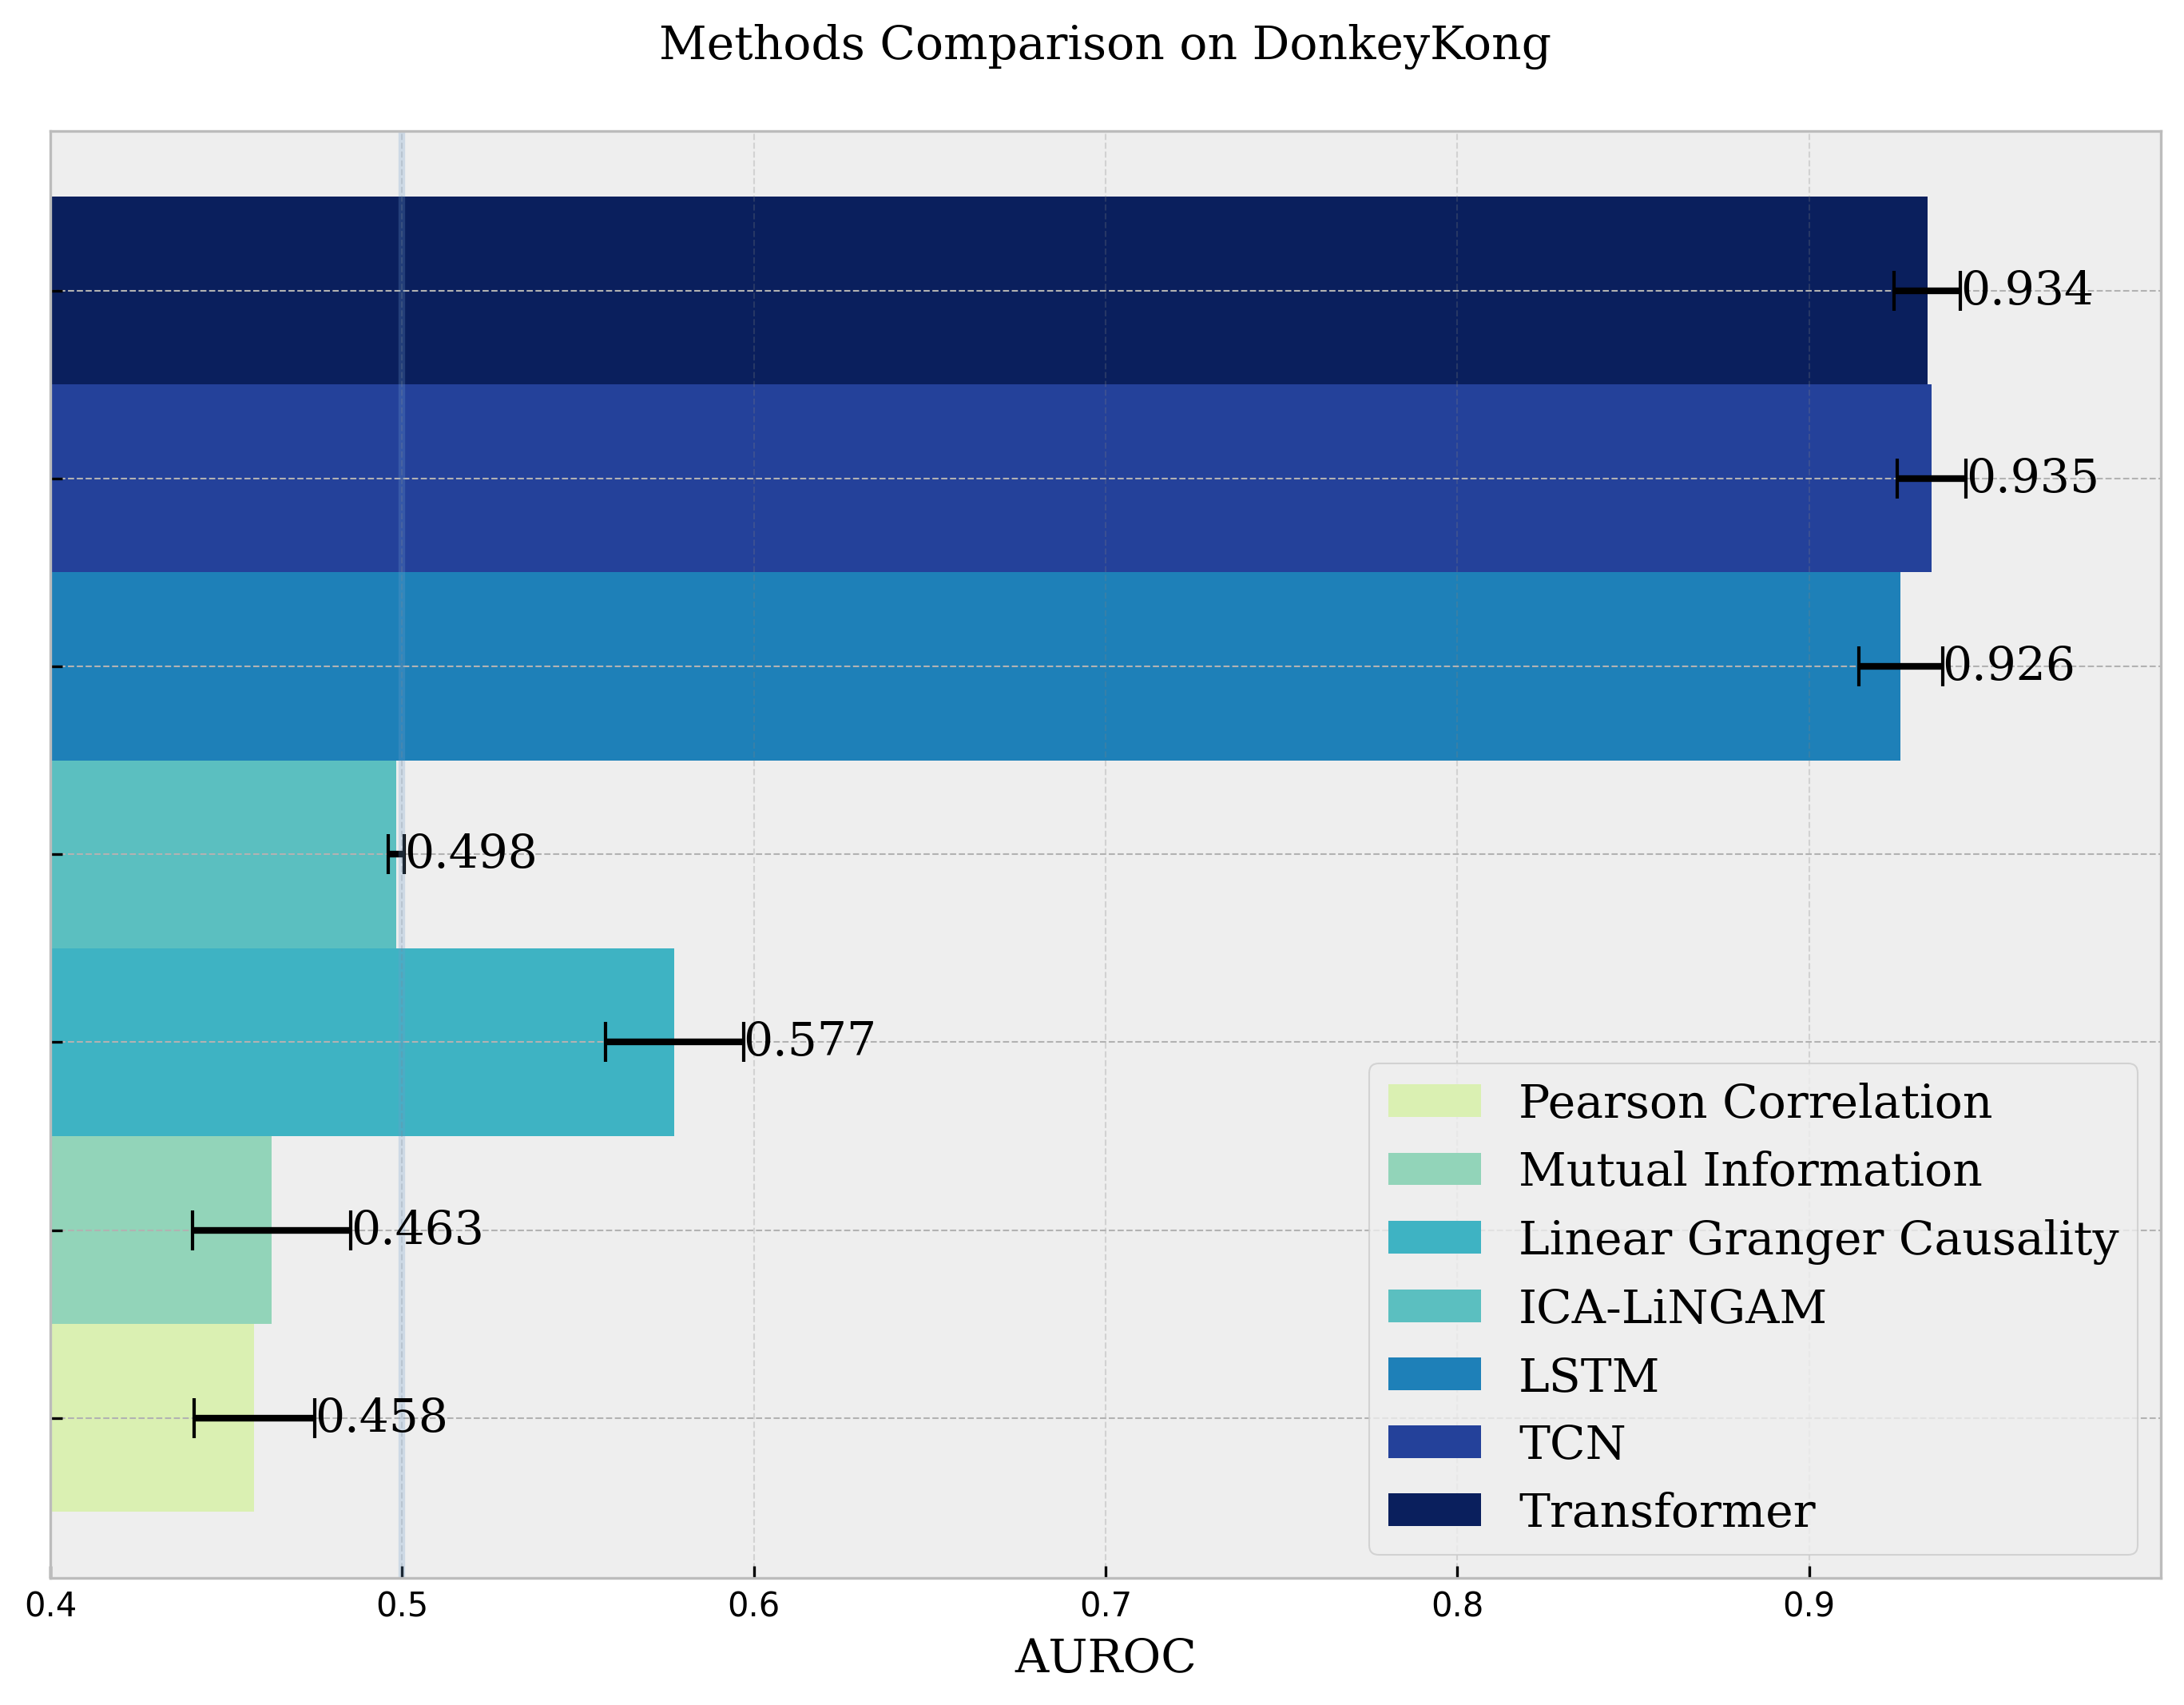

In [10]:
plot_regular_results(result, error_bar=True, conditions=['0.3noise'])

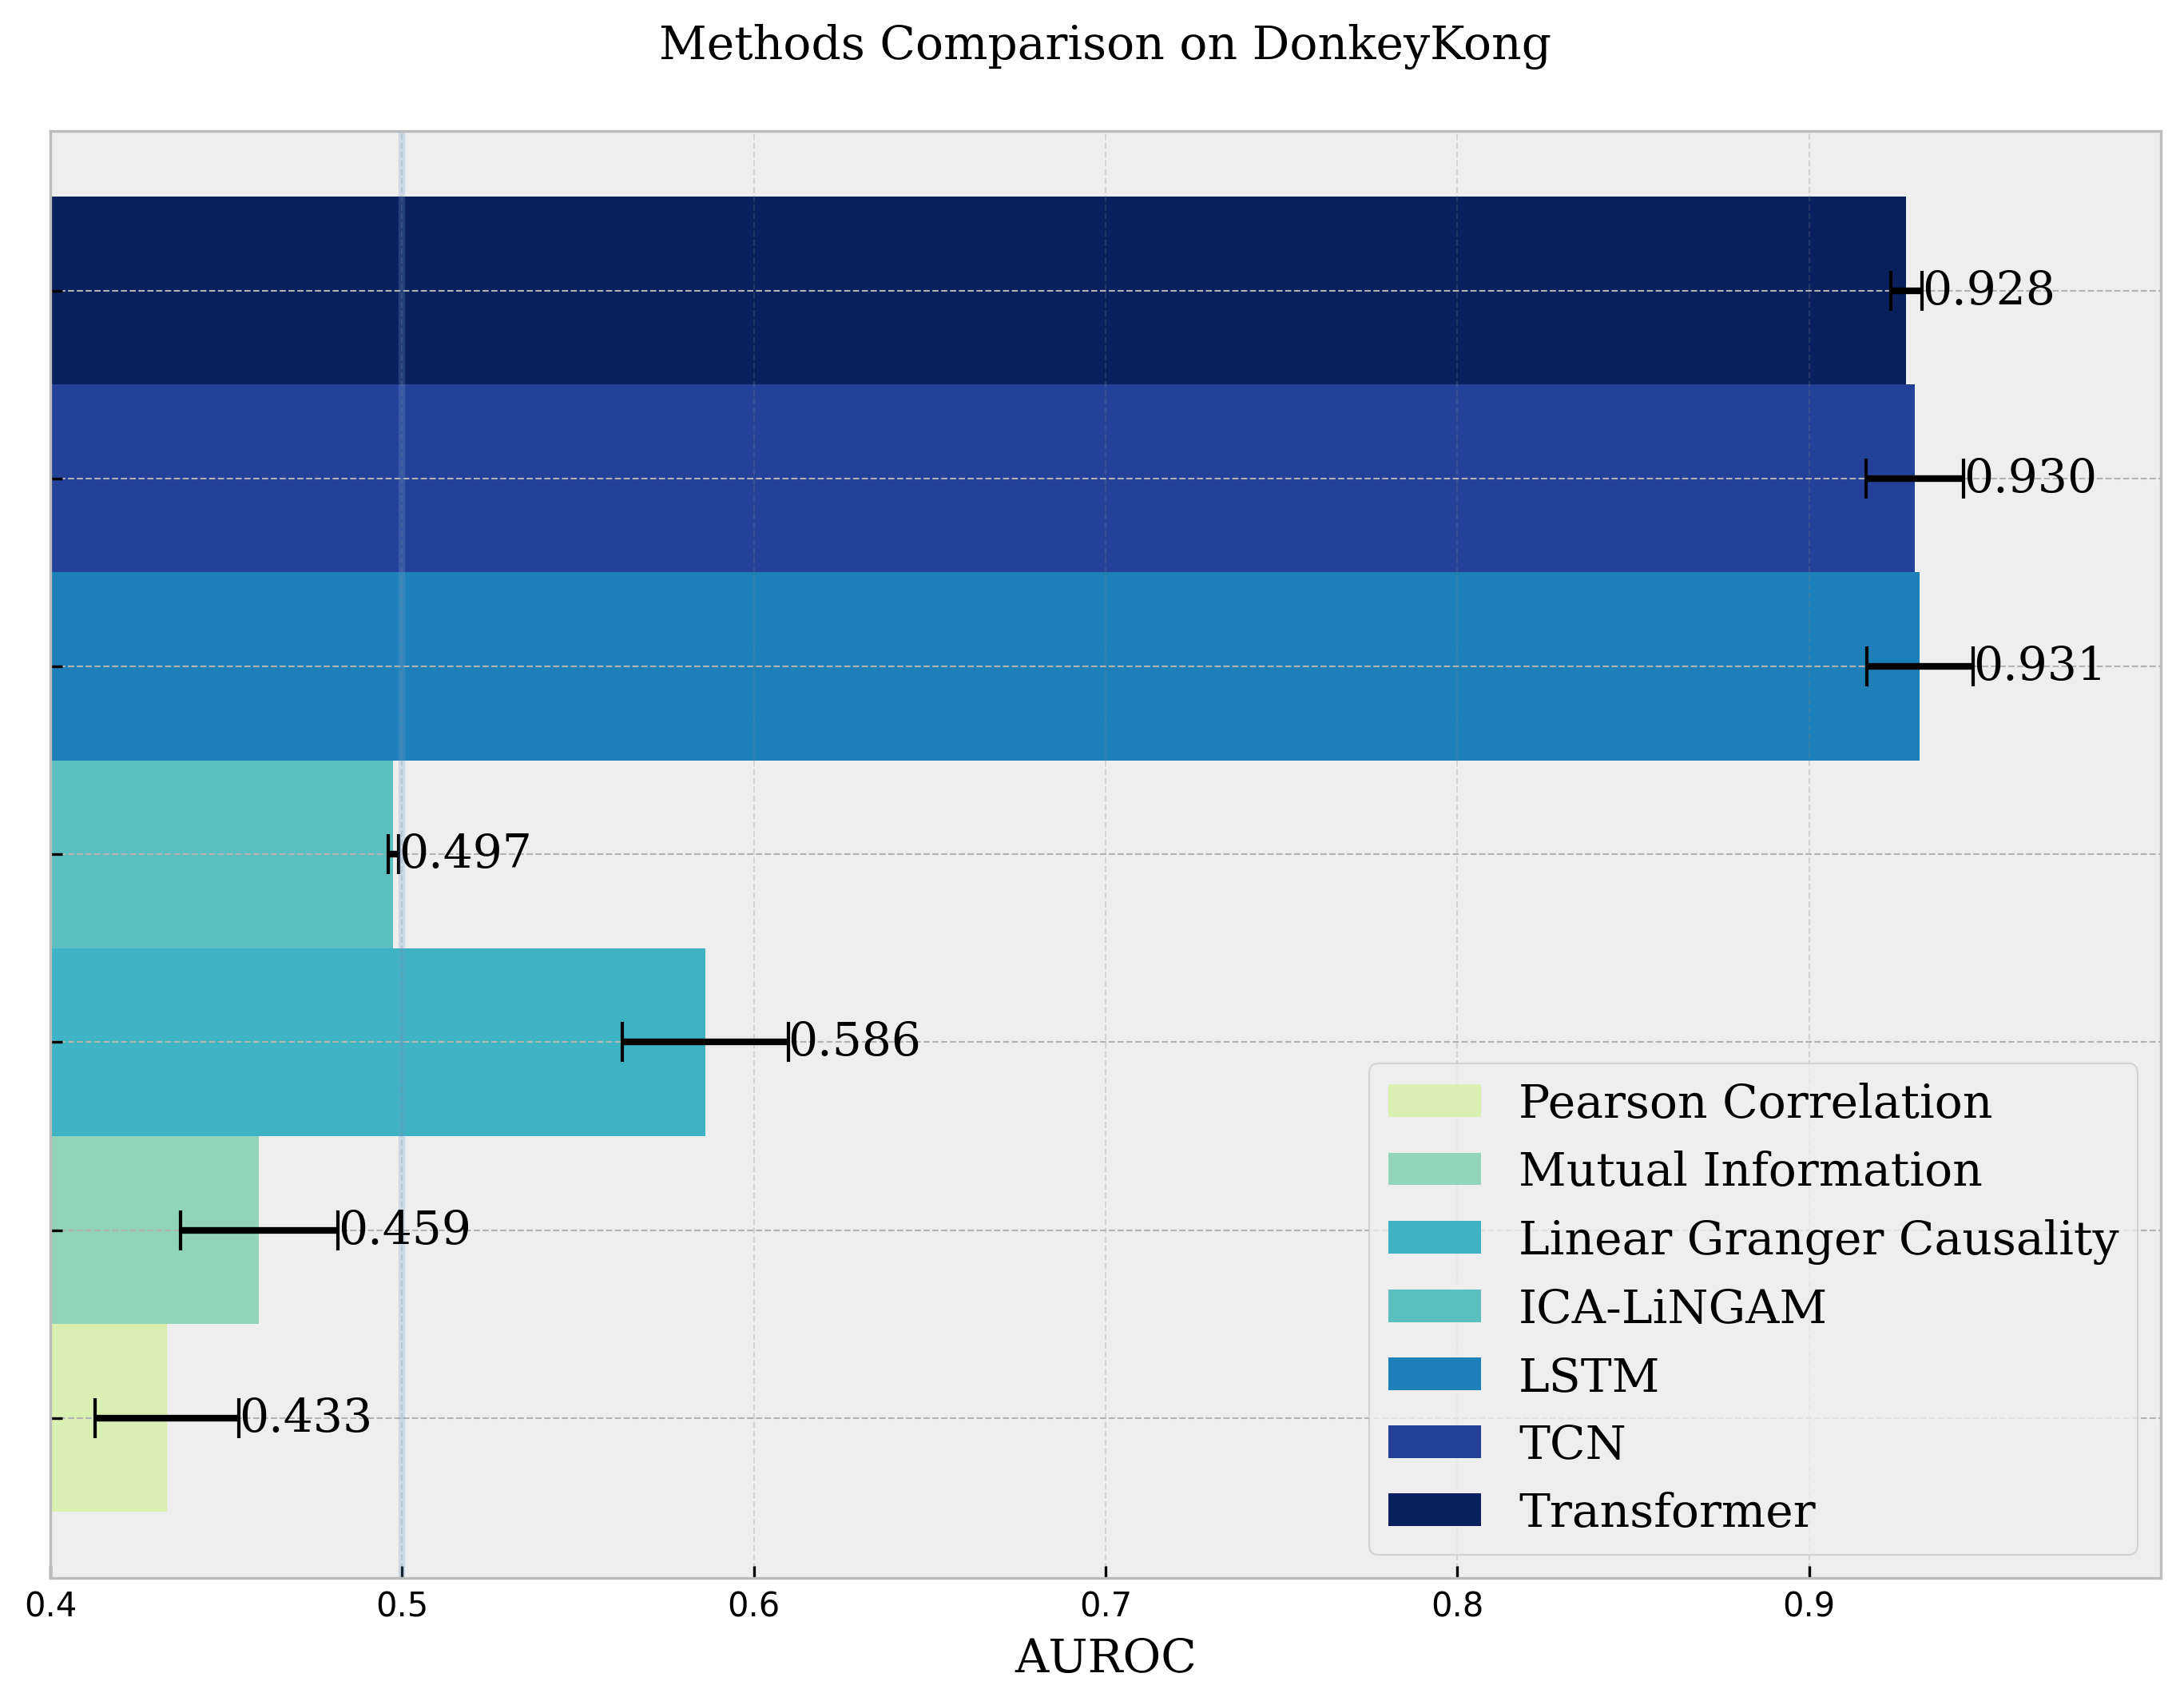

In [11]:
plot_regular_results(result, error_bar=True, conditions=['0.5noise'])

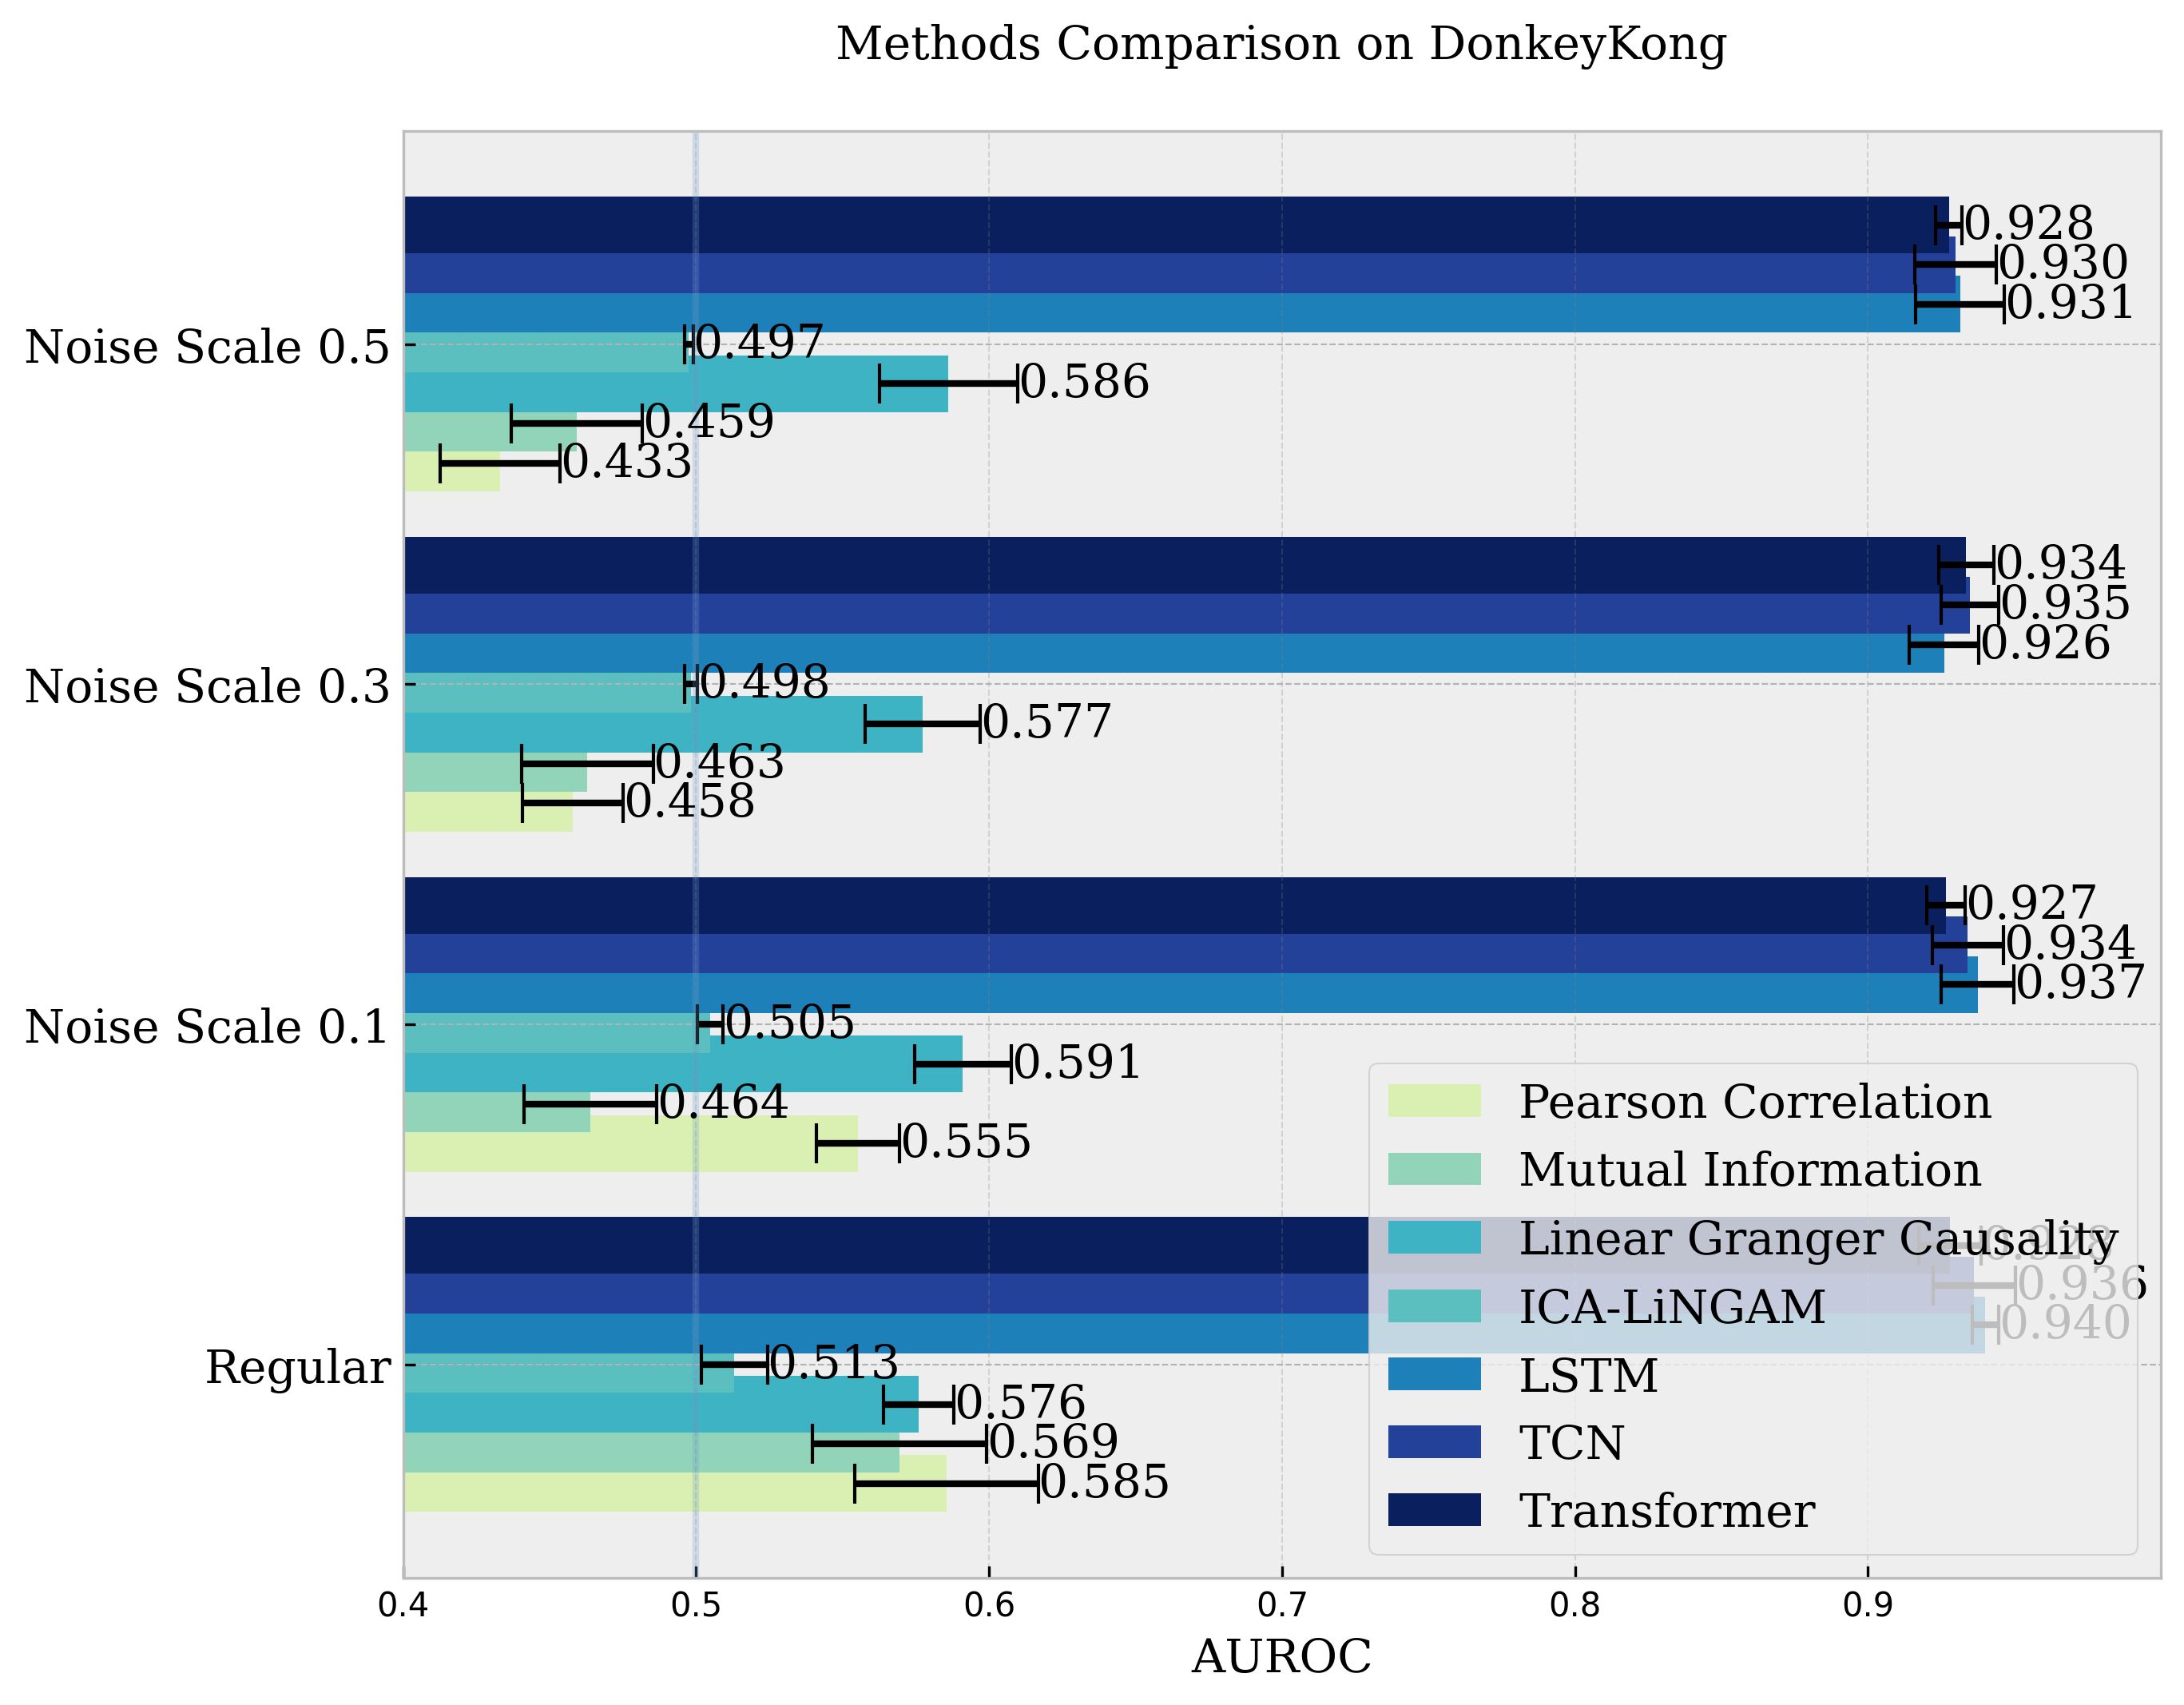

In [12]:
y_labels = ['Regular', 'Noise Scale 0.1', 'Noise Scale 0.3', 'Noise Scale 0.5']
plot_regular_results(result, conditions=['default', '0.1noise', '0.3noise', '0.5noise'],
                     error_bar=True, plot_kwargs={'y_labels': y_labels, 'bar_height':0.5, 'interval': 3},
                     save_dir='figures/Figure 4. Methods/noise')

### Cross Game

In [13]:
# prediction by different seeds
cross_result = {}
condition = 'default'

# collect inference result from traditional methods
cross_result = collect_inferences(file_cfg={'game': ['DonkeyKong', 'Pitfall', 'SpaceInvaders'],
                                        'method': ['corr', 'mi', 'gc', 'lingam'],
                                        'seed': [42],
                                        'note': [condition]}, target_dir='.cache/sim_data/mos_auc_result')
# get result from deep learning method
for game in ['DonkeyKong', 'Pitfall', 'SpaceInvaders']:
    def testset_modifier(cfg):
        cfg.test.data_root = f'.cache/sim_data/{game}/HR/' + 'Regular_3510_step_256_rec_2e3.npy'
        cfg.test.split = f'.cache/sim_data/{game}/csv/fold_seed_42/' + 'test_sim_grouped.csv'
        return cfg
    cross_result[condition][game] = models_inference(['fold_seed_42'], result=cross_result[condition][game], screen=['noise'], target_dir=work_dir, cfg_hook=testset_modifier)


total models number: 3


0it [00:00, ?it/s]/home/charon/anaconda3/envs/dev_test/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)

TCN: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:24<00:00,  1.04it/s]
1it [00:25, 25.37s/it]/home/charon/anaconda3/envs/dev_test/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)

Transformer: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:24<00:00,  1.04it/s

total models number: 3


0it [00:00, ?it/s]/home/charon/anaconda3/envs/dev_test/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)

TCN: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:18<00:00,  1.05s/it]
1it [00:19, 19.17s/it]/home/charon/anaconda3/envs/dev_test/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)

Transformer: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:18<00:00,  1.01s/it

total models number: 3


0it [00:00, ?it/s]/home/charon/anaconda3/envs/dev_test/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)

TCN: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:22<00:00,  1.01s/it]
1it [00:22, 22.62s/it]/home/charon/anaconda3/envs/dev_test/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)

Transformer: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:21<00:00,  1.01it/s

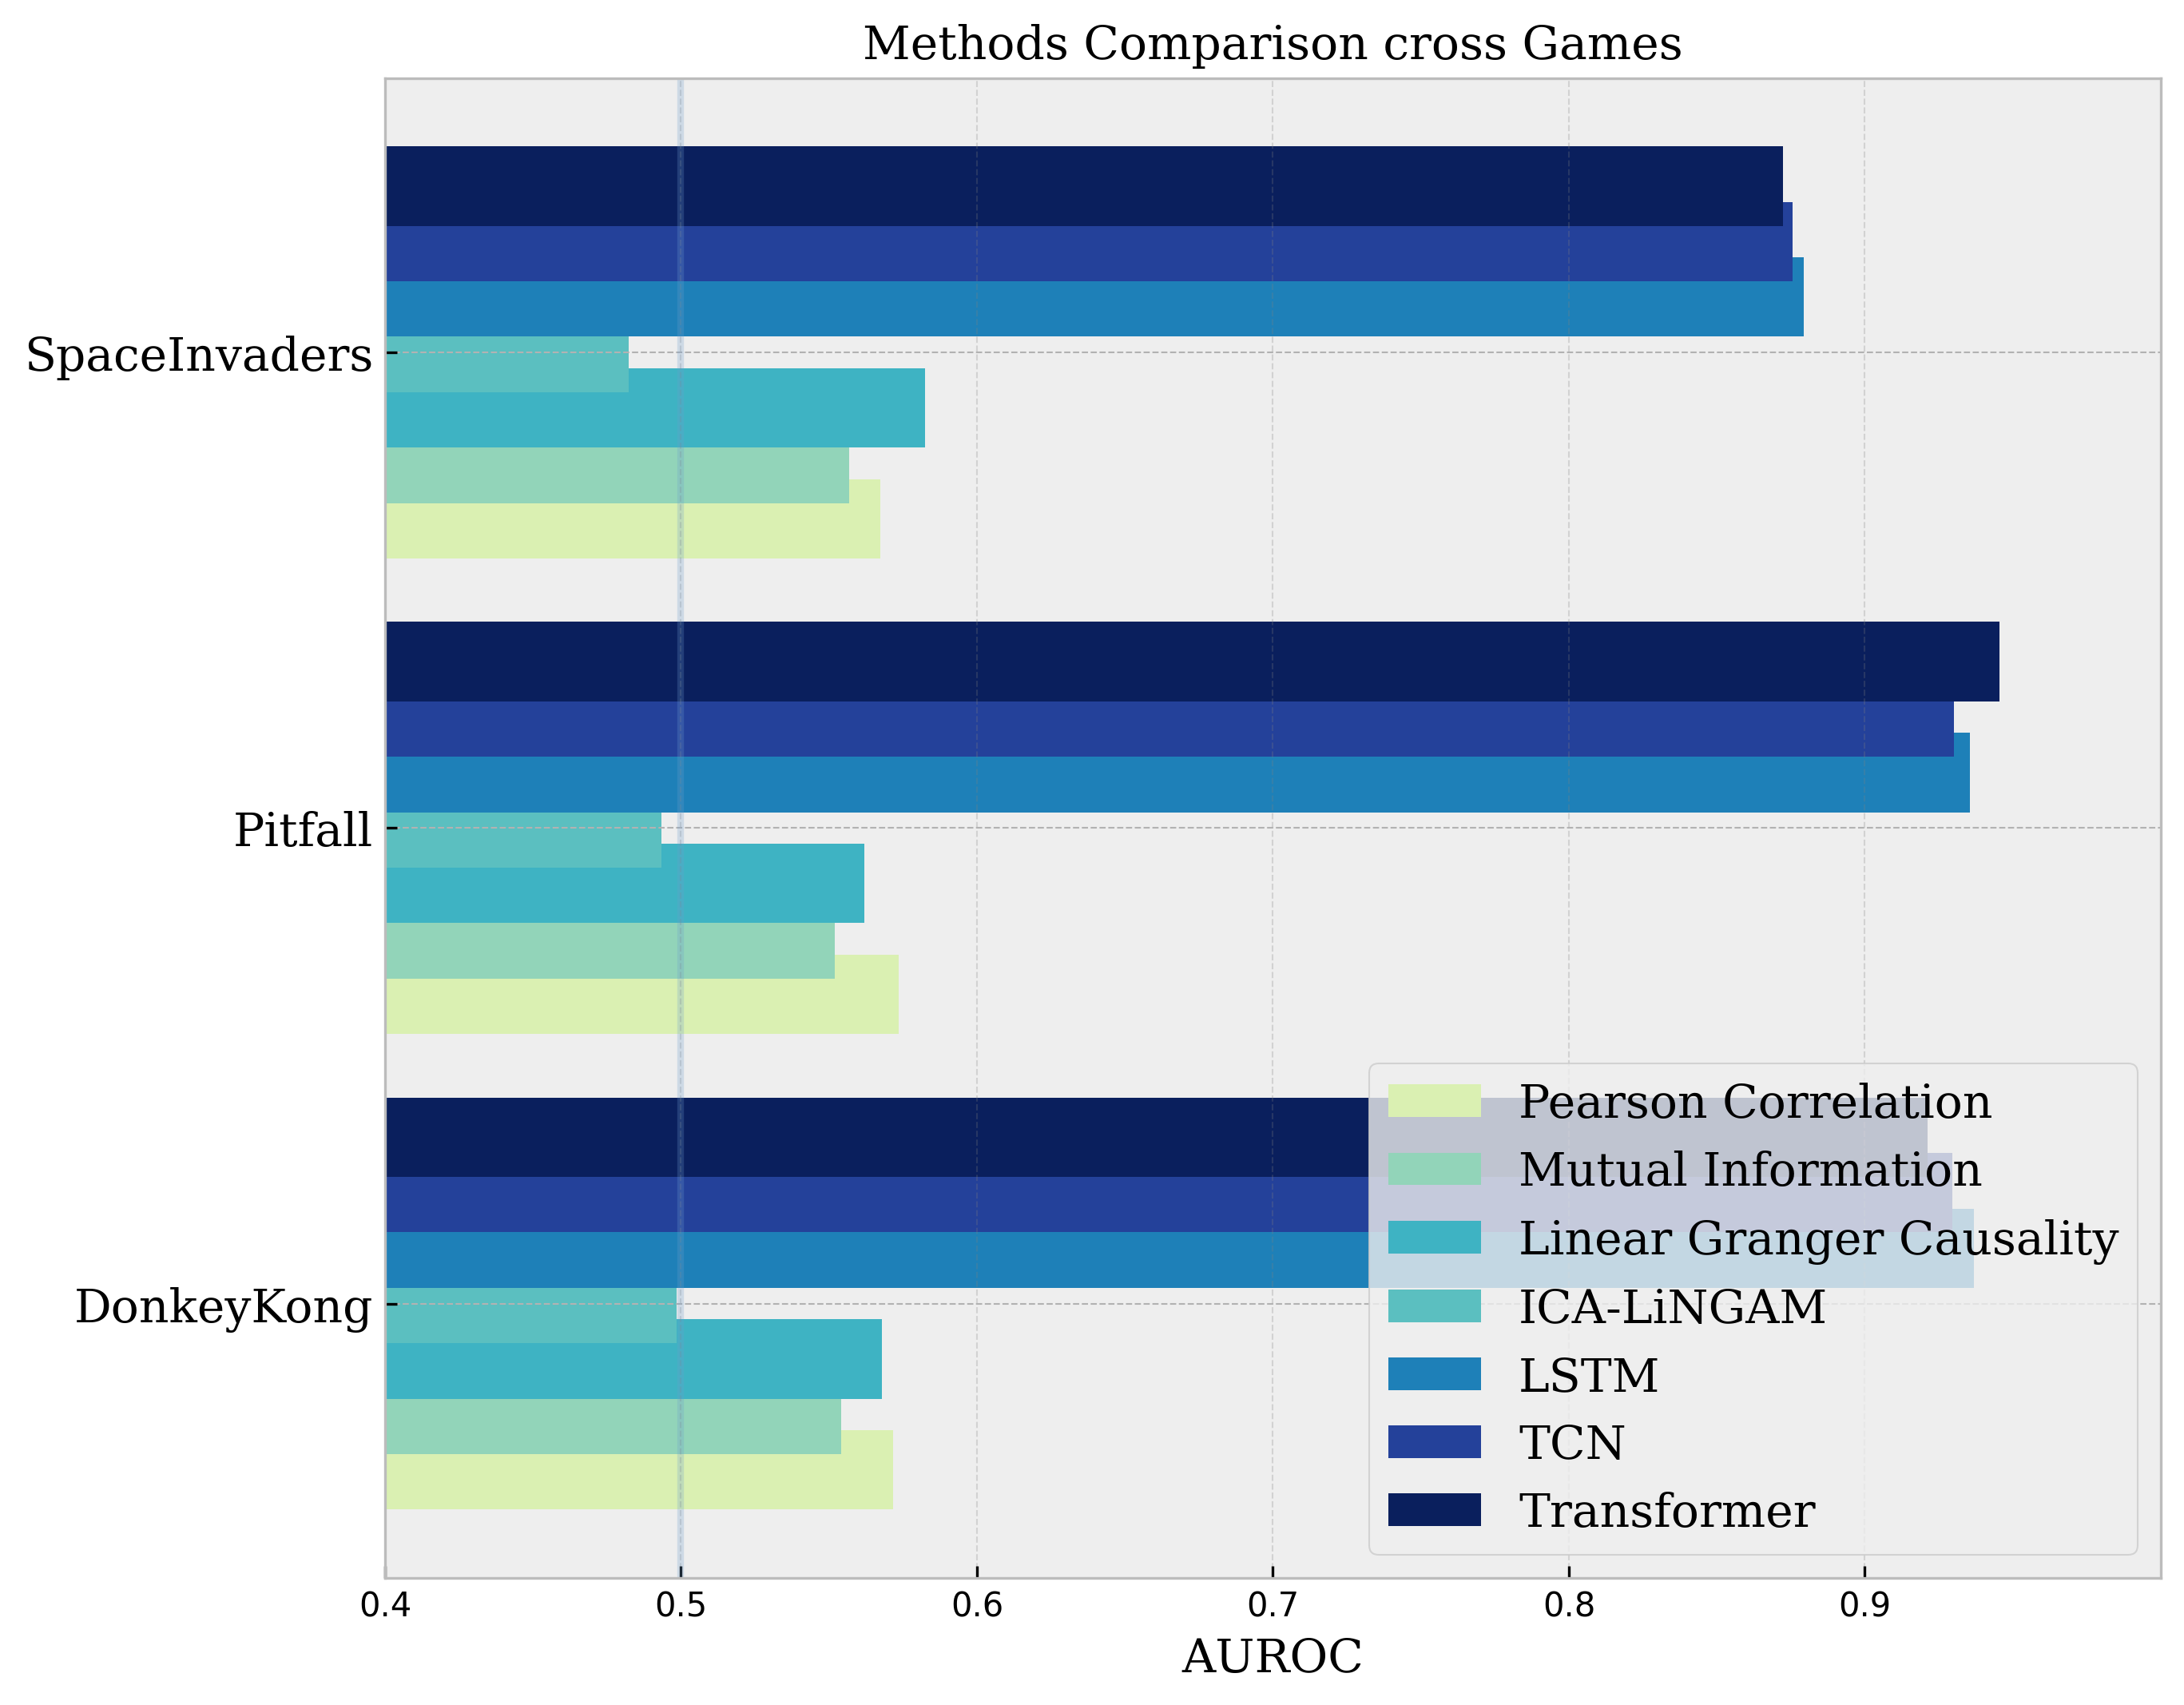

In [14]:
y_labels = ['DonkeyKong', 'Pitfall', 'SpaceInvaders']
# wrap the dict format to match the plot function
_cross_result = {k: {k: cross_result['default'][k]} for k, v in cross_result['default'].items()}
plot_regular_results(_cross_result, conditions=y_labels,
                     plot_kwargs={'y_labels': y_labels, 'bar_height':0.5, 'interval': 3,
                                  'title': 'Methods Comparison cross Games'},
                     save_dir='figures/Figure 4. Methods/game')

# NetSim

### Checkpoint Inference

In [10]:
# model inference
def eval_netsim(cfg, ckpt, sim='default', add_noise=False):
    di, mi = prepare_inference(cfg, ckpt)
    mi = mi.cuda()
    if sim != 'default':
        di.data_cfg.test.data_root = sim
        di.data_cfg.test.percentage = [0.6, 1.0]
        if add_noise:
            di.data_cfg.test.pipeline = [dict(type='TsAug', transforms=[dict(type='AddNoise', scale=0.5, normalize=True, seed=42)]),
                                         dict(type='ToTensor')]
    di.setup(stage='test')
    di.data_cfg.test_batch_size = 1024*10
    di.data_cfg.test_batch_size = 1024*10
    dl = di.test_dataloader()
    preds = []
    labels = []
    mi.eval()
    with torch.no_grad():
        for i, (x, y) in tqdm(enumerate(dl), total=len(dl), desc=f'{mi.hparams.model.backbone.type}'):
            pred = mi({k: v.cuda() for k, v in x.items()})
            preds.append(pred.softmax(dim=-1)[:, 1].detach().cpu())
            labels.append(y.detach().cpu())

        preds = torch.cat(preds, dim=0)
        labels = torch.cat(labels, dim=0)
    return preds, labels


In [11]:
# directory of netsim dataset
netsim_dir = '.cache/netsim'
sims = [f'{netsim_dir}/sim{i}.mat' for i in [1, 2, 3, 4, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24]]

mi_dicts = cfg_ckpt2dict(search_cfg_ckpt(keyword=['netsim', 'partial', 'transformer'], screen=['lag', 'norm'], target_dir=root_dir))

cfgs, ckpts = [], []
for k, v in mi_dicts.items():
    cfgs.append(k)
    ckpts.append(v)
cfg, ckpt = cfgs[0], ckpts[0]

print(f'total models number: {len(mi_dicts)}')

total models number: 1


### Load precomputed result of other methods in NetSim and calculate AUC
since doing inference by traditional methods is time consuming, we precomputed the result and save it in `.cache/sim_data/default_result.pkl` and `.cache/sim_data/noise_result.pkl` as we mentioned in the appendix.
result = {'mi': [{'pred': pred, 'label': label}...], 'gc': [{'pred': pred, 'label': label}...]}

In [12]:
lcd_auc = []
for sim in sims:
    preds, labels = eval_netsim(cfg, ckpt, sim=sim)
    # auc
    lcd_auc.append(auroc(preds, labels))

graph_auc = {}
default_result = pickle.load(open('.cache/sim_data/netsim_auc_result/default_result.pkl', 'rb'))
pred_sldisco, pred_ges, pred_gc, pred_mi, pred_lingam = default_result['sldisco'], default_result['ges'], default_result['gc'],  default_result['mi'], default_result['lingam']

netsim_dir = '.cache/netsim'
sims = [f'{netsim_dir}/sim{i}.mat' for i in [1, 2, 3, 4, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24]]

# iterate over all the methods
for method, pred in zip(['sldisco', 'ges', 'gc', 'mi', 'lingam'], [pred_sldisco, pred_ges, pred_gc, pred_mi, pred_lingam]):
    auc = []
    for sim, res in zip(sims, pred):
        # auc
        if not pred[sim]:
            # for ges gc
            assert method in ['ges', 'gc'], 'only ges and gc have no result'
            auc.append(np.nan)
        else:
            dd = [(np.array(d['pred']).reshape(-1), np.where(np.array(d['label'])!=0, 1, 0).reshape(-1)) for d in pred[sim]]
            auc.append(auroc(torch.from_numpy(np.concatenate([d[0] for d in dd])).to(torch.float32), torch.from_numpy(np.concatenate([d[1] for d in dd])).to(torch.int32)))
    graph_auc[method] = auc

/home/charon/anaconda3/envs/dev_test/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Transformer: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]


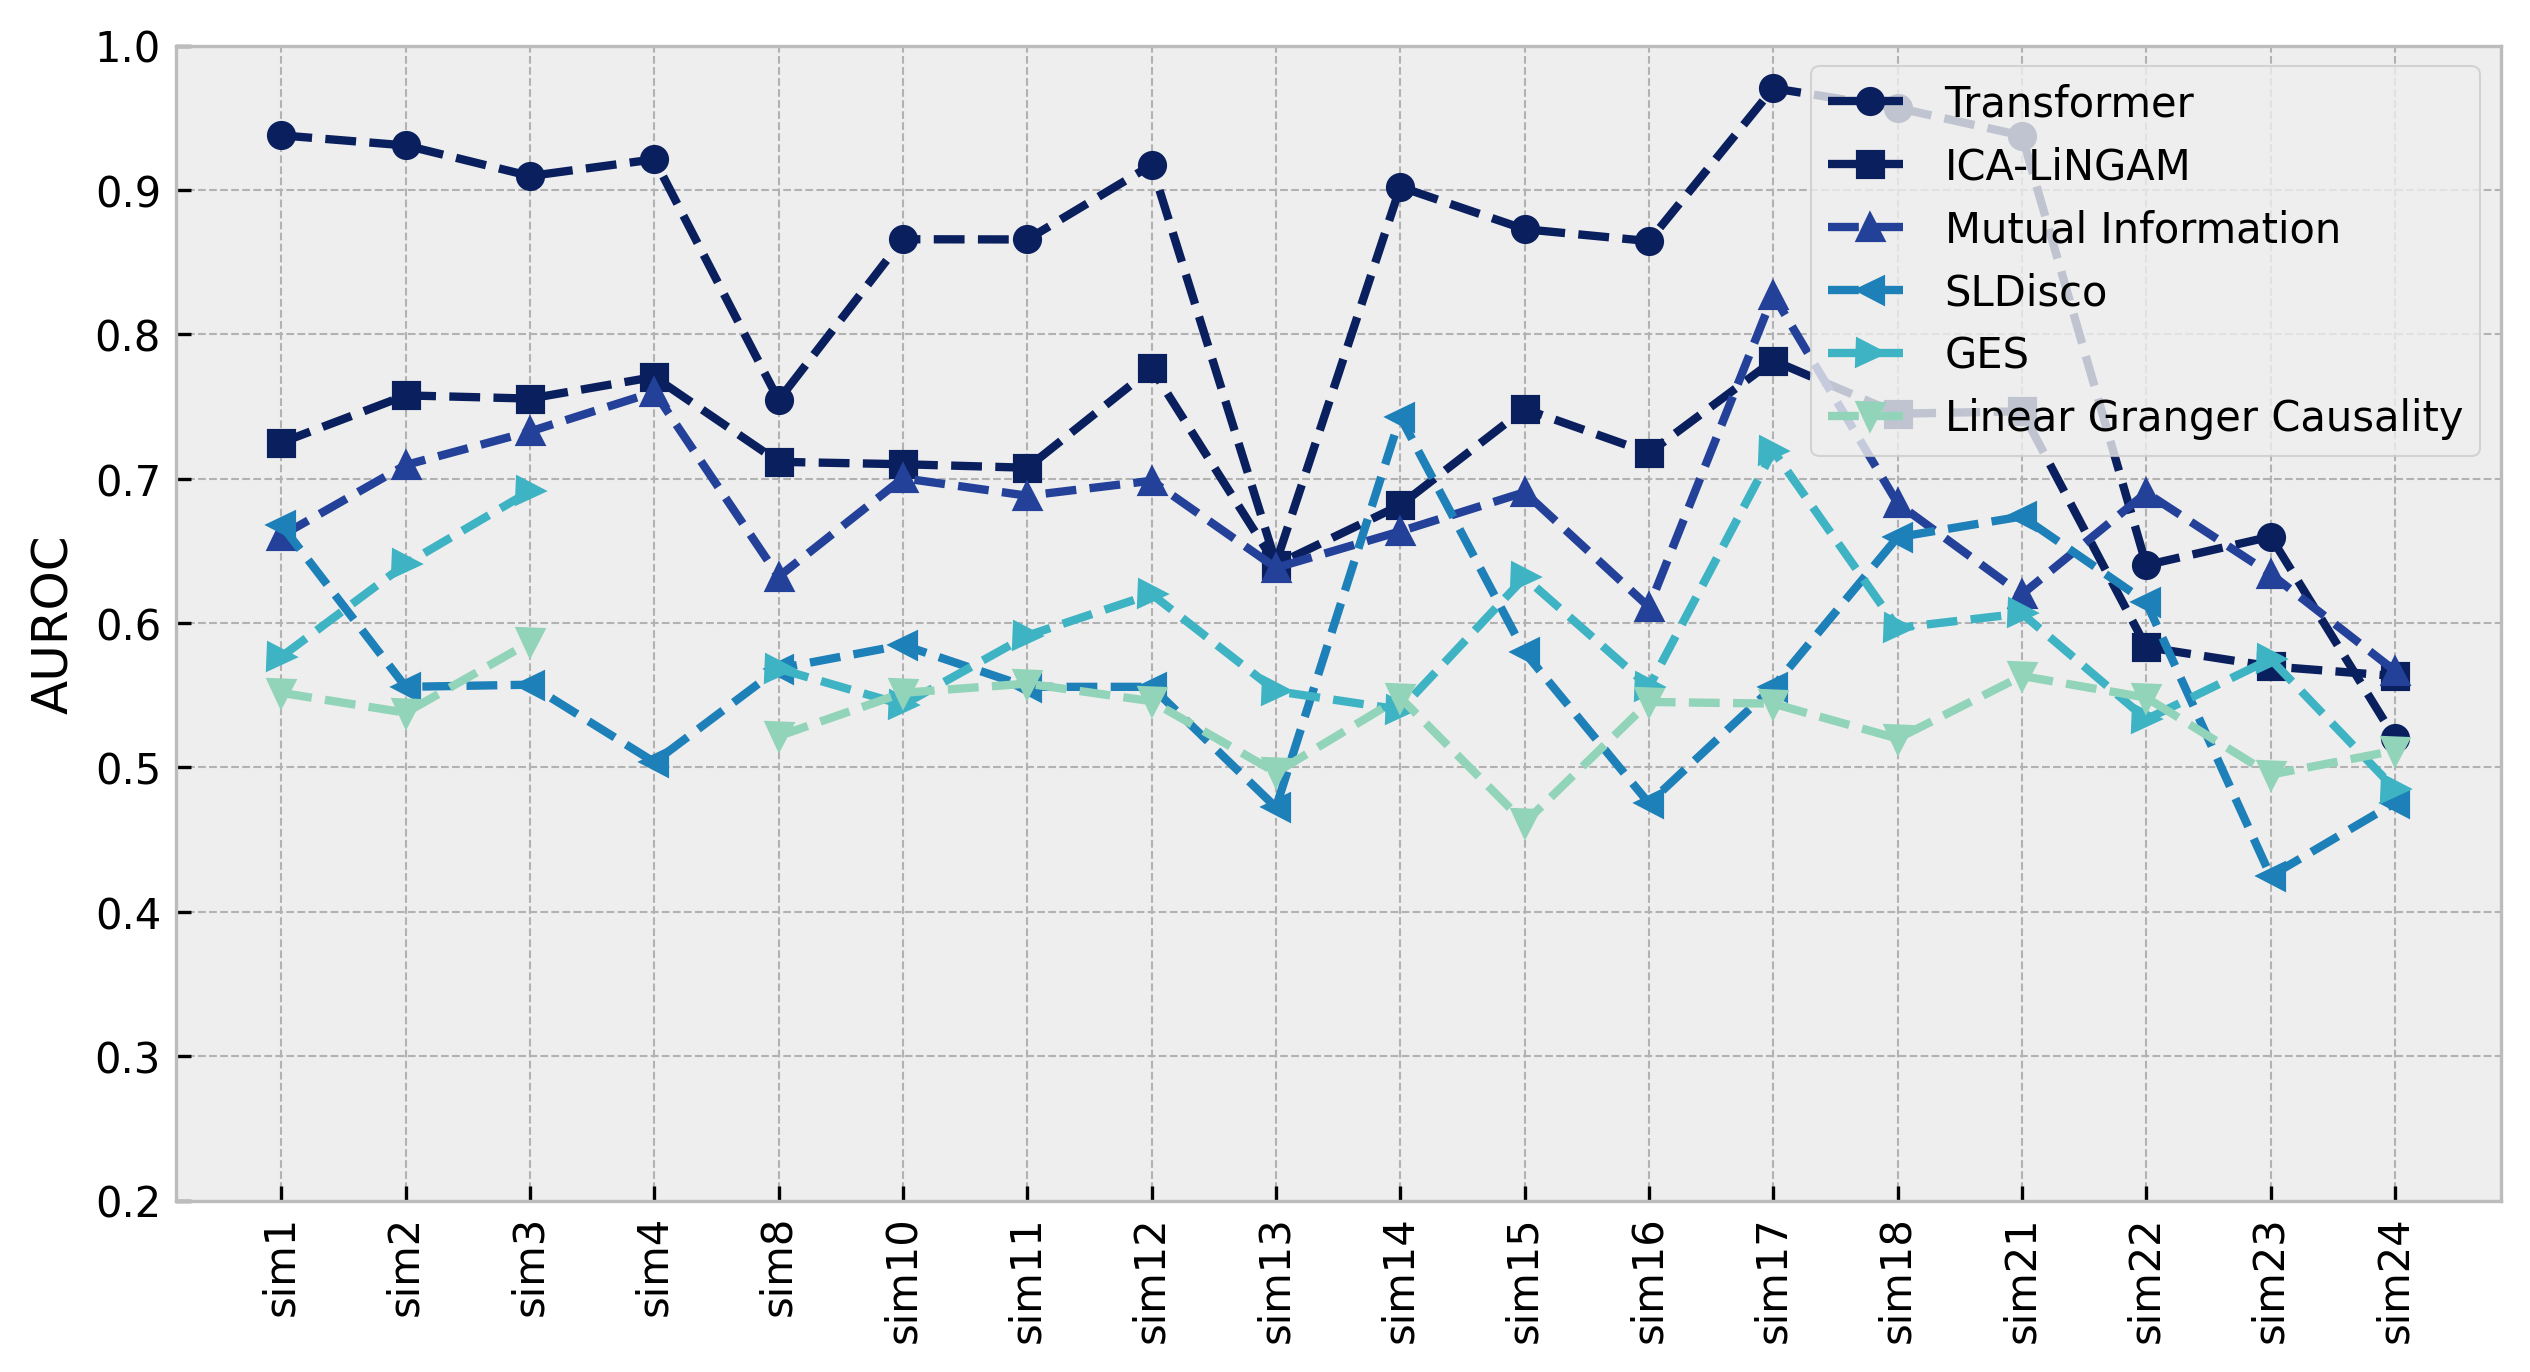

In [13]:
# default

import matplotlib.pyplot as plt

sldisco_auc, ges_auc, gc_auc, mi_auc, lingam_auc = graph_auc['sldisco'], graph_auc['ges'], \
                                                   graph_auc['gc'], graph_auc['mi'], graph_auc['lingam']

cls = [218, 240, 178, 146, 212, 185, 62, 179, 195, 30, 128, 184, 36, 65, 154, 10,31, 93]

def digits2color(digits):
    d_group = [digits[i:i+3] for i in range(0, len(digits), 3)]
    colors = [tuple((np.array(d)/255).tolist()) for d in d_group]
    return colors
cls = digits2color(cls)

plt.figure(figsize=(10, 5), dpi=300)
plt.plot(lcd_auc, linestyle='--', marker='o', color=cls[-1], label='Transformer')
plt.plot(lingam_auc, linestyle='--', marker='s', color=cls[5], label='ICA-LiNGAM')
plt.plot(mi_auc, linestyle='--', marker='^', color=cls[4], label='Mutual Information')
plt.plot(sldisco_auc, linestyle='--', marker='<', color=cls[3], label='SLDisco')
plt.plot(ges_auc, linestyle='--', marker='>', color=cls[2], label='GES')
plt.plot(gc_auc, linestyle='--', marker='v', color=cls[1], label='Linear Granger Causality')
plt.xticks(range(len(sims)), [sim.split('/')[-1].strip('.mat') for sim in sims ], rotation=90)
plt.ylim(0.2, 1.0)
plt.ylabel('AUROC')
plt.legend(loc='upper right')
plt.savefig('figures/Figure 6. NetSim/default_result.svg')

Transformer: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.03s/it]


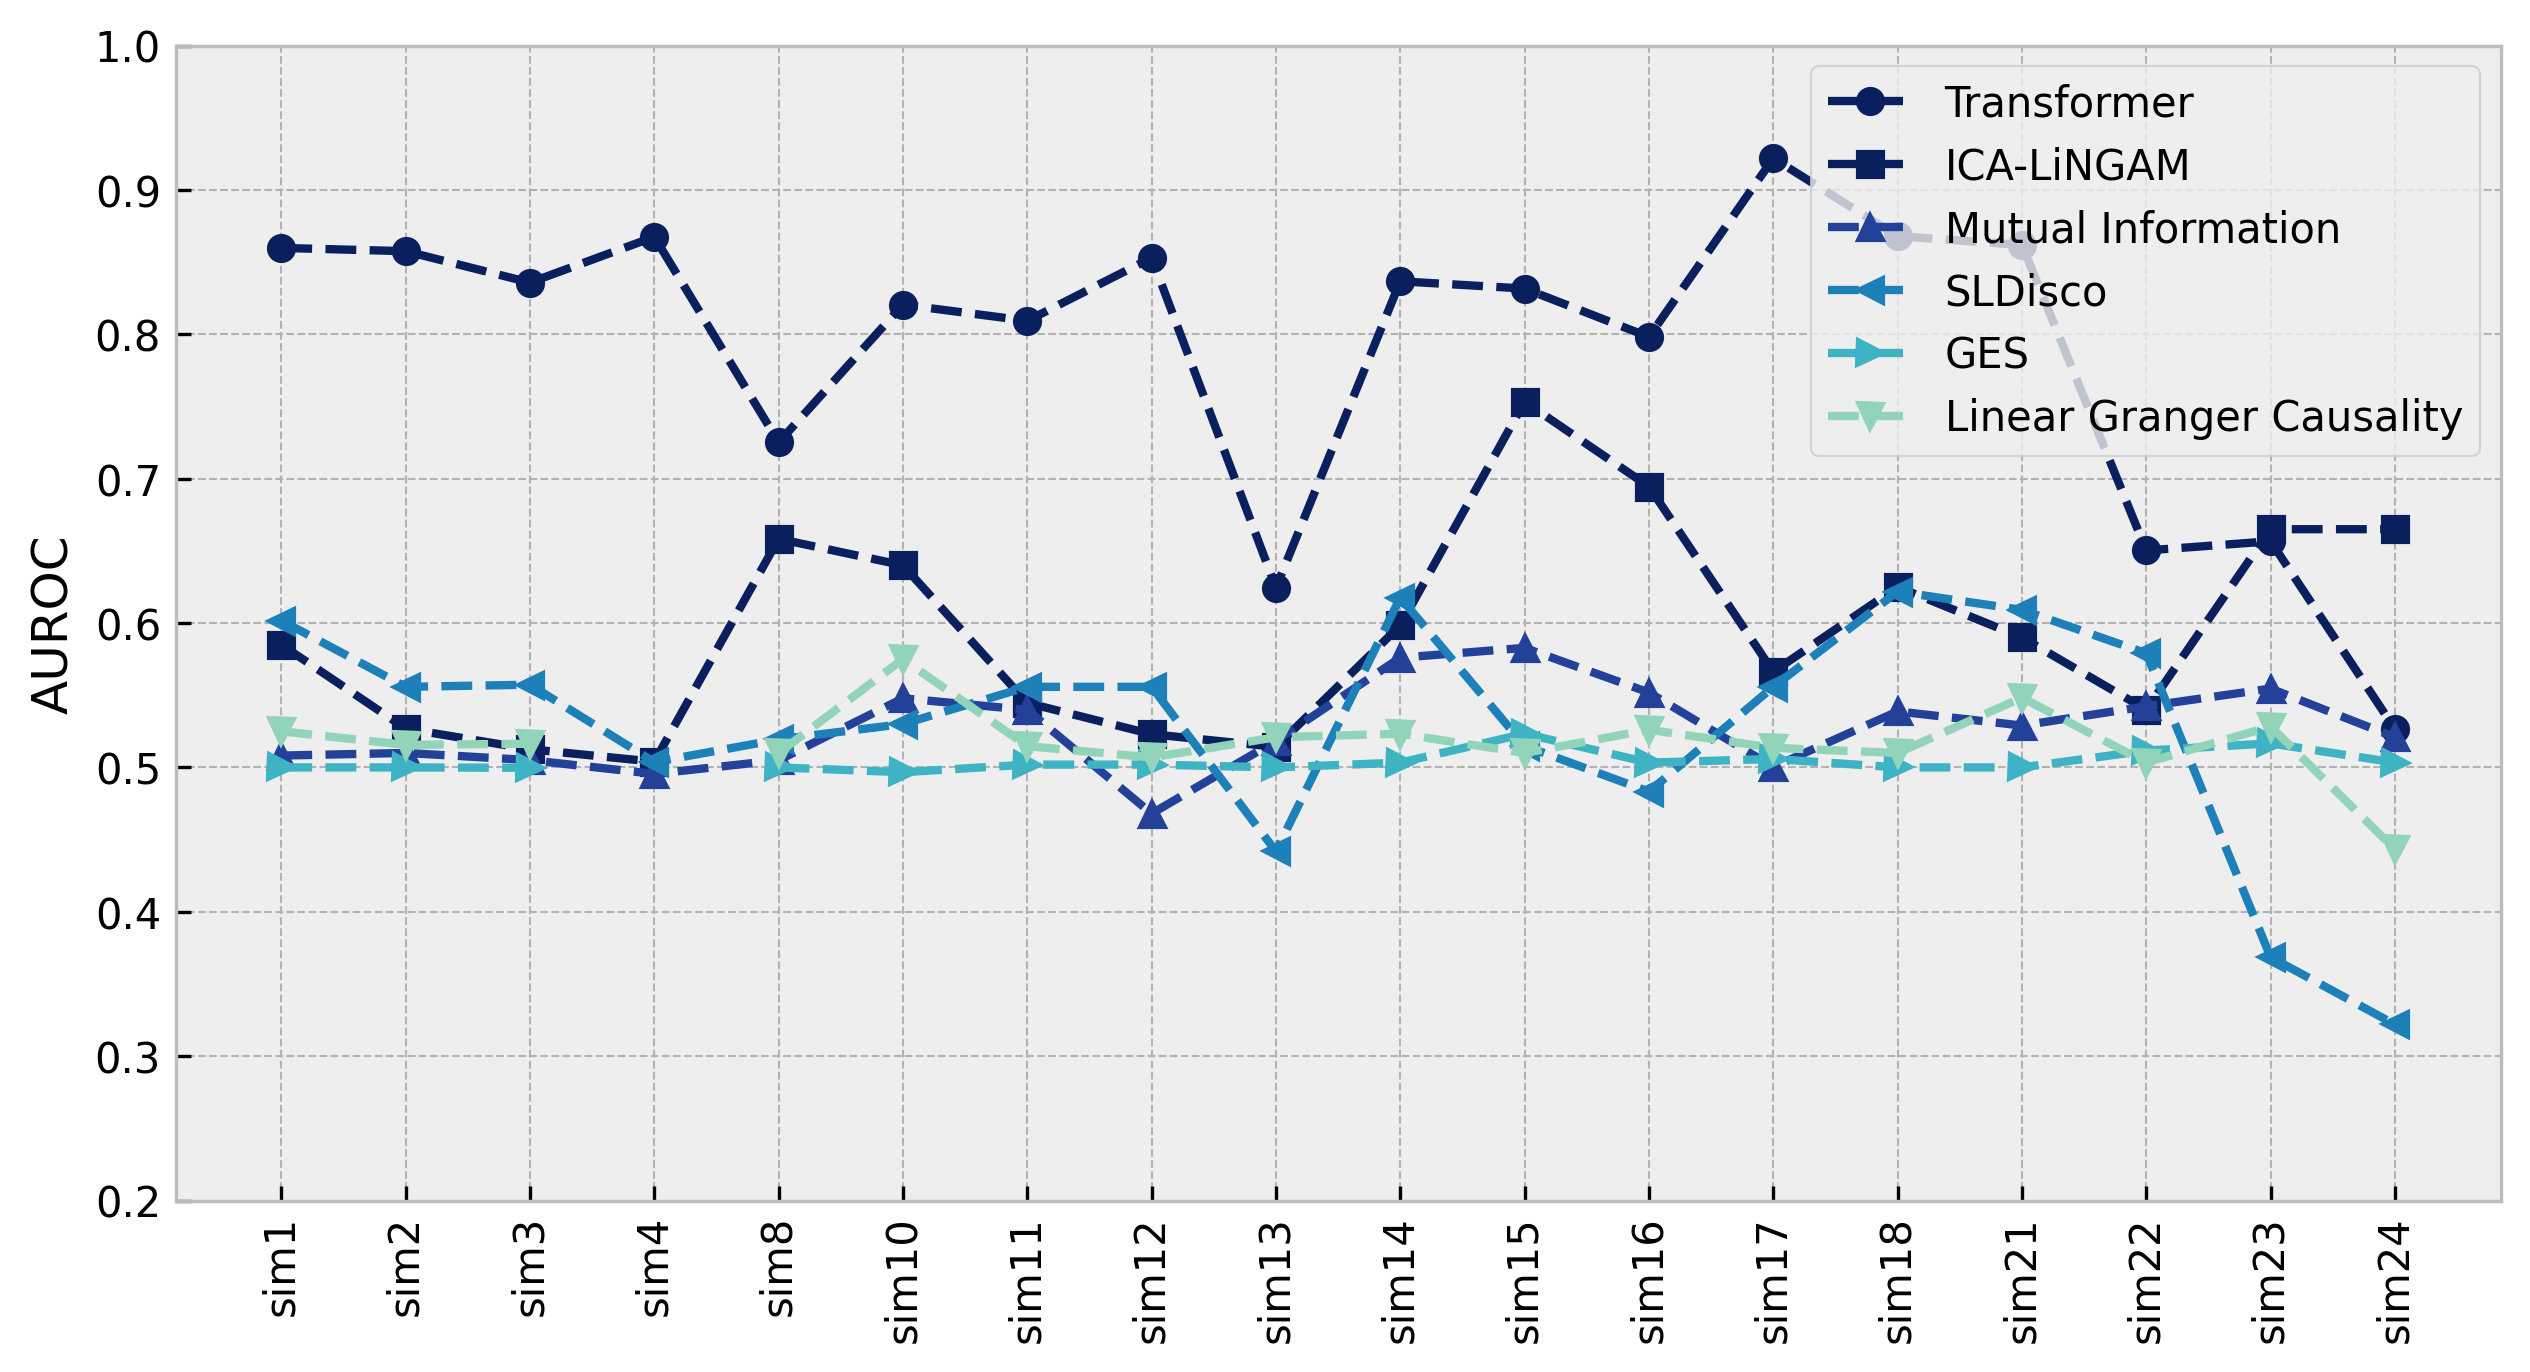

In [15]:
# noise
lcd_auc = []
for sim in sims:
    preds, labels = eval_netsim(cfg, ckpt, sim=sim, add_noise=True)
    # auc
    lcd_auc.append(auroc(preds, labels))

graph_auc = {}
noise_result = pickle.load(open('.cache/sim_data/netsim_auc_result/noise_result.pkl', 'rb'))
pred_sldisco, pred_ges, pred_gc, pred_mi, pred_lingam = noise_result['sldisco'], noise_result['ges'], noise_result['gc'], noise_result['mi'], noise_result['lingam']

# iterate over all the methods
for method, pred in zip(['sldisco', 'ges', 'gc', 'mi', 'lingam'], [pred_sldisco, pred_ges, pred_gc, pred_mi, pred_lingam]):
    auc = []
    for sim, res in zip(sims, pred):
        # auc
        if not pred[sim]:
            # for ges gc
            assert method in ['ges', 'gc'], 'only ges and gc have no result'
            auc.append(np.nan)
        else:
            dd = [(np.array(d['pred']).reshape(-1), np.where(np.array(d['label'])!=0, 1, 0).reshape(-1)) for d in pred[sim]]
            auc.append(auroc(torch.from_numpy(np.concatenate([d[0] for d in dd])).to(torch.float32), torch.from_numpy(np.concatenate([d[1] for d in dd])).to(torch.int32)))
    graph_auc[method] = auc

sldisco_auc, ges_auc, gc_auc, mi_auc, lingam_auc = graph_auc['sldisco'], graph_auc['ges'], \
                                                   graph_auc['gc'], graph_auc['mi'], graph_auc['lingam']

cls = [218, 240, 178, 146, 212, 185, 62, 179, 195, 30, 128, 184, 36, 65, 154, 10,31, 93]

def digits2color(digits):
    d_group = [digits[i:i+3] for i in range(0, len(digits), 3)]
    colors = [tuple((np.array(d)/255).tolist()) for d in d_group]
    return colors
cls = digits2color(cls)

plt.figure(figsize=(10, 5), dpi=300)
plt.plot(lcd_auc, linestyle='--', marker='o', color=cls[-1], label='Transformer')
plt.plot(lingam_auc, linestyle='--', marker='s', color=cls[5], label='ICA-LiNGAM')
plt.plot(mi_auc, linestyle='--', marker='^', color=cls[4], label='Mutual Information')
plt.plot(sldisco_auc, linestyle='--', marker='<', color=cls[3], label='SLDisco')
plt.plot(ges_auc, linestyle='--', marker='>', color=cls[2], label='GES')
plt.plot(gc_auc, linestyle='--', marker='v', color=cls[1], label='Linear Granger Causality')
plt.xticks(range(len(sims)), [sim.split('/')[-1].strip('.mat') for sim in sims], rotation=90)
plt.ylim(0.2, 1.0)
plt.ylabel('AUROC')
plt.legend(loc='upper right')
plt.savefig('figures/Figure 6. NetSim/noise_result.svg')